# <span style="color:#0b486b">  Student Information</span>
***
Surname: **Zhang**  <br/>
Firstname: **Yiming**    <br/>
Student ID: **35224436**    <br/>
Email: **yzha1213@student.monash.edu**    <br/>
Your tutorial time: **Wed 12pm**    <br/>
***

## <span style="color:#0b486b">Part 3: Convolutional Neural Networks and Image Classification</span>

**<div style="text-align: right"><span style="color:red">[Total marks for this part: 45 points]</span></div>**

The third part of this assignment is to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 3 to 6**. Going through these materials before attempting this assignment is highly recommended.

**The dataset used for this part is a specific dataset for this unit consisting of approximately $10,000$ images of $20$ classes of Animals, each of which has approximately 500 images. You can download the dataset at [download here](https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link) if you want to do your assignment on your machine.**


In [4]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

torch.manual_seed(1234)

CUDA is not available.  Training on CPU ...


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Copy the dataset files from Google Drive to the current directory
!cp "/content/drive/My Drive/FIT5215 Deep learning/Animals_Dataset.zip" "/content/"
!cp "/content/drive/My Drive/FIT5215 Deep learning/fit-5215-object-detection-s-2-2025.zip" "/content/"

Download the dataset to the folder of this Google Colab.

In [15]:
# !gdown --fuzzy https://drive.google.com/file/d/10Y65ykpja1t6UWt3imPPbZkqhe0kOPL9/view?usp=sharing # new url v1
# !gdown --fuzzy https://drive.google.com/file/d/1uc7uQ5myz7k74ZO460Q04B35_GekQeGi/view?usp=sharing # new url v2



We unzip the dataset to the folder.

In [16]:
# !unzip -q Animals_Dataset_v1.zip
# !unzip -q Animals_Dataset_v2.zip
!unzip -q Animals_Dataset.zip
!unzip -q fit-5215-object-detection-s-2-2025.zip

In [17]:
data_dir = "./FIT5215_Dataset"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

Number of instance in train_set: 8519
Number of instance in val_set: 947


In [18]:
class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']

In [19]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [20]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

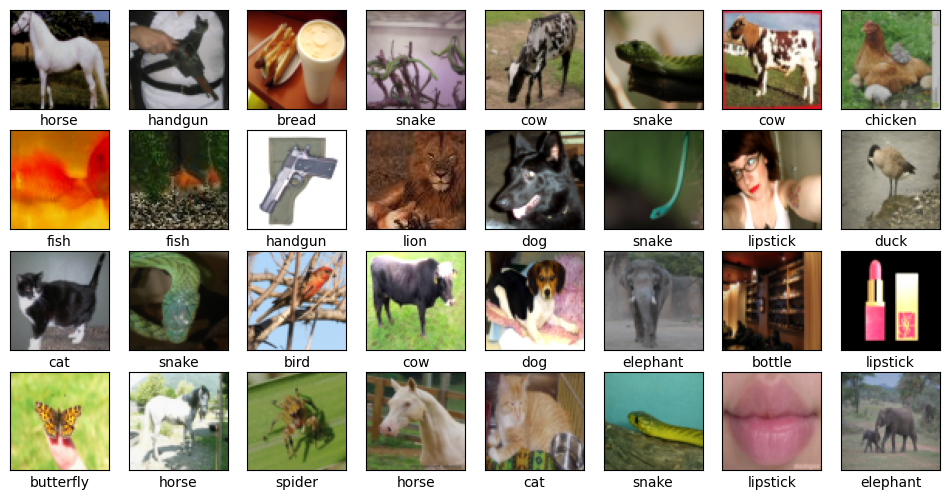

In [21]:
visualize_data(images, labels)

**For questions 3.1 to 3.7, you'll need to write your own model in a way that makes it easy for you to experiment with different architectures and parameters. The goal is to be able to pass the parameters to initialize a new instance of `YourModel` to build different network architectures with different parameters. Below are descriptions of some parameters for `YourModel`:**

1. `Block confirguration`: Our network consists of many blocks. Each block has the pattern `[conv, batch norm, activation, conv, batch norm, activation, max pool, dropout]`. All convolutional layers have filter size $(3, 3)$, strides $(1, 1)$ and padding = 1, and all max pool layers have strides $(2, 2)$, kernel size $2$, and padding = 0. The network will consists of a few blocks before applying a linear layer to output the logits for the softmax layer.

2. `list_feature_maps`: the number of feature maps in the blocks of the network. For example, if `list_feature_maps = [16, 32, 64]`, our network has two blocks with the input_channels or number of feature maps are `16, 32`, and `64` respectively.
3. `drop_rate`: the keep probability for dropout. Setting `drop_rate` to $0.0$ means not using dropout.
4. `batch_norm`: the batch normalization function is used or not. Setting `batch_norm` to `false` means not using batch normalization.
5. `use_skip`: the skip connection is used in the blocks or not. Setting this to `true` means that we use `1x1` Conv2D with `strides=2` for the skip connection.
6. At the end, you need to apply `global average pooling (GAP)` (`AdaptiveAvgPool2d((1, 1))`) to flatten the 3D output tensor before defining the output linear layer for predicting the labels.



Here is the model confirguration of `YourCNN` if the `list_feature_maps = [16, 32, 64]` and `batch_norm = true`.

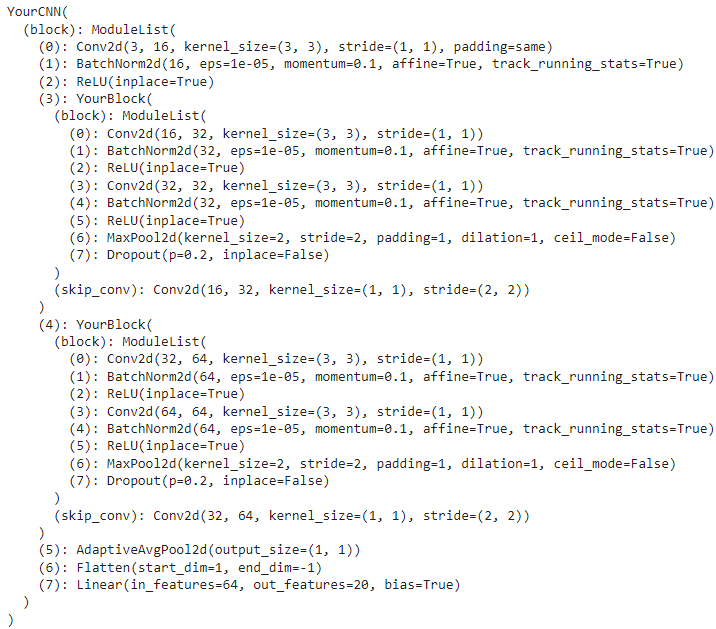

### <span style="color:red">**Question 3.1:**</span> **You need to implement the aforementioned CNN**.

**First, you need to implement the block of our CNN in the class `YourBlock`. You can ignore `use_skip` and `skip connection` for simplicity. However, you cannot earn full marks for this question.**

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [22]:
class YourBlock(nn.Module):
  def __init__(self, in_feature_maps, out_feature_maps, drop_rate = 0.2, batch_norm = True, use_skip = True):
    super(YourBlock, self).__init__()
    self.use_skip = use_skip
    #Your code here
    self.batch_norm = batch_norm
    self.drop_rate = drop_rate

    # Create the block layers: [conv, batch norm, activation, conv, batch norm, activation, max pool, dropout]
    layers = []

    # First conv layer (3x3, stride=1, padding=1)
    layers.append(nn.Conv2d(in_feature_maps, out_feature_maps, kernel_size=3, stride=1, padding=1))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_feature_maps))
    layers.append(nn.ReLU(inplace=True))

    # Second conv layer (3x3, stride=1, padding=1)
    layers.append(nn.Conv2d(out_feature_maps, out_feature_maps, kernel_size=3, stride=1, padding=1))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_feature_maps))
    layers.append(nn.ReLU(inplace=True))

    # Max pooling (kernel=2, stride=2, padding=0)
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

    # Dropout
    if drop_rate > 0:
        layers.append(nn.Dropout(drop_rate))

    self.block = nn.ModuleList(layers)

    # Skip connection: 1x1 Conv2D with stride=2 for dimension matching
    if use_skip:
        if in_feature_maps != out_feature_maps:
            # Need 1x1 conv to match channels and downsample by 2
            self.skip_conv = nn.Conv2d(in_feature_maps, out_feature_maps, kernel_size=1, stride=2)
        else:
            # Same channels, just need to downsample by 2
            self.skip_conv = None
    else:
        self.skip_conv = None

  def forward(self, x):
    # Store input for skip connection
    identity = x

    # Forward through all layers in the block
    for layer in self.block:
        x = layer(x)

    # Apply skip connection if enabled
    if self.use_skip:
        if self.skip_conv is not None:
            # Use 1x1 conv to match dimensions
            identity = self.skip_conv(identity)
        else:
            # Just downsample with max pooling to match spatial dimensions
            identity = nn.functional.max_pool2d(identity, kernel_size=2, stride=2)

        # Add skip connection
        x = x + identity

    return x




**Second, you need to use the above `YourBlock` to implement the class `YourCNN`**.

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [23]:
class YourCNN(nn.Module):
  def __init__(self, list_feature_maps = [16, 32, 64], drop_rate = 0.2, batch_norm= True, use_skip = True):
    super(YourCNN, self).__init__()

    # Build the network using YourBlock
    layers = []

    # First layer: convert from 3 input channels to first feature map size
    layers.append(nn.Conv2d(3, list_feature_maps[0], kernel_size=3, stride=1, padding=1))
    if batch_norm:
        layers.append(nn.BatchNorm2d(list_feature_maps[0]))
    layers.append(nn.ReLU(inplace=True))

    # Add YourBlocks for each feature map transition
    for i in range(len(list_feature_maps) - 1):
        in_channels = list_feature_maps[i]
        out_channels = list_feature_maps[i + 1]
        layers.append(YourBlock(in_channels, out_channels, drop_rate, batch_norm, use_skip))

    self.block = nn.ModuleList(layers)

    self.block.extend(
      [
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(list_feature_maps[-1], 20)
      ]
    )

  def forward(self, x):
    # Forward through all blocks
    for layer in self.block:
        x = layer(x)
    return x


**We declare `my_cnn` from `YourCNN` as follows**.

In [24]:
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)
print(my_cnn)

YourCNN(
  (block): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): YourBlock(
      (block): ModuleList(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Dropout(p=0.2, inplace=False)
      )
      (skip_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (4): YourBlock(
      (block): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)

**We declare the optimizer and the loss function.**

In [25]:
# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

**Here are the codes to compute the loss and accuracy.**

In [26]:
def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [27]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

**Here is the code to train our model.**

In [28]:

def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 10, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device) # Move the model to the GPU

  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:
      # Move input data to the same device as the model
      X,y = X.to(device), y.to(device)
      # Forward pass
      outputs = model(X.type(torch.float32)) # X is already on the correct device
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()
      #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    if not verbose: #verbose = True means we do show the training information during training
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

In [29]:
history = fit(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs=10, verbose = False)

Epoch 1/10
train loss= 2.4719 - train acc= 24.73% - valid loss= 2.4586 - valid acc= 24.18%
Epoch 2/10
train loss= 2.1124 - train acc= 32.27% - valid loss= 2.1857 - valid acc= 28.51%
Epoch 3/10
train loss= 1.9012 - train acc= 40.30% - valid loss= 1.9676 - valid acc= 37.91%
Epoch 4/10
train loss= 1.7846 - train acc= 44.69% - valid loss= 1.8246 - valid acc= 44.03%
Epoch 5/10
train loss= 1.8677 - train acc= 42.68% - valid loss= 1.9037 - valid acc= 40.76%
Epoch 6/10
train loss= 1.6675 - train acc= 47.25% - valid loss= 1.7107 - valid acc= 46.36%
Epoch 7/10
train loss= 1.5925 - train acc= 50.59% - valid loss= 1.6413 - valid acc= 49.52%
Epoch 8/10
train loss= 1.4387 - train acc= 54.98% - valid loss= 1.4574 - valid acc= 53.22%
Epoch 9/10
train loss= 1.4738 - train acc= 52.99% - valid loss= 1.5290 - valid acc= 51.32%
Epoch 10/10
train loss= 1.5165 - train acc= 51.21% - valid loss= 1.6161 - valid acc= 48.89%


### <span style="color:red">**Question 3.2:**</span> **Now, let us tune the number of blocks, $use\_skip \in \{true,false\}$ and $learning\_rate \in \{0.001, 0.0005\}$. Write your code for this tuning and report the result of the best model on the testing set. Note that you need to show your code for tuning and evaluating on the test set to earn the full marks. During tuning, you can set the instance variable `verbose` of your model to `True` for not showing the training details of each epoch.**

Note that for this question, depending on your computational resource, you can choose `list_feature_maps= [32, 64]` or `list_feature_maps= [16, 32, 64]`.

<div style="text-align: right"> <span style="color:red">[3 points]</span> </div>

##### Training model

In [30]:
# Define hyperparameter search space
hyperparams = {
    "use_skip": [True, False],
    "learning_rate": [0.001, 0.0005],
    "list_feature_maps": [[32, 64]],  # [16, 32, 64]
}

# Store results
results = []
best_val_acc = 0
best_config = None
best_model = None
best_history = None

print("Starting hyperparameter tuning for Question 3.2...")
print("=" * 60)

# Grid search over hyperparameters
config_num = 0
total_configs = (
    len(hyperparams["use_skip"])
    * len(hyperparams["learning_rate"])
    * len(hyperparams["list_feature_maps"])
)

for use_skip in hyperparams["use_skip"]:
    for lr in hyperparams["learning_rate"]:
        for feature_maps in hyperparams["list_feature_maps"]:
            config_num += 1

            print(f"\nConfiguration {config_num}/{total_configs}:")
            print(f"  use_skip: {use_skip}")
            print(f"  learning_rate: {lr}")
            print(f"  list_feature_maps: {feature_maps}")
            print("-" * 40)

            # Create model with current configuration
            model = YourCNN(
                list_feature_maps=feature_maps,
                drop_rate=0.2,
                batch_norm=True,
                use_skip=use_skip,
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Train model
            start_time = time.time()
            history = fit(
                model=model,
                train_loader=train_loader,
                valid_loader=val_loader,
                optimizer=optimizer,
                num_epochs=10,
                verbose=True,  # Hide training details
                seed=1234,
            )
            training_time = time.time() - start_time

            # Get final metrics
            final_val_acc = history["val_acc"][-1]
            final_train_acc = history["train_acc"][-1]
            final_val_loss = history["val_loss"][-1]
            final_train_loss = history["train_loss"][-1]

            # Store results
            config_result = {
                "use_skip": use_skip,
                "learning_rate": lr,
                "list_feature_maps": feature_maps,
                "final_val_acc": final_val_acc,
                "final_train_acc": final_train_acc,
                "final_val_loss": final_val_loss,
                "final_train_loss": final_train_loss,
                "training_time": training_time,
                "history": history,
            }
            results.append(config_result)

            print(f"Results:")
            print(
                f"  Train accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)"
            )
            print(f"  Val accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
            print(f"  Train loss: {final_train_loss:.4f}")
            print(f"  Val loss: {final_val_loss:.4f}")
            print(f"  Training time: {training_time:.1f}s")

            # Update best model if this configuration is better
            if final_val_acc > best_val_acc:
                best_val_acc = final_val_acc
                best_config = config_result.copy()
                best_model = model
                best_history = history
                print(f"  *** NEW BEST MODEL! ***")

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING COMPLETED")
print("=" * 60)

Starting hyperparameter tuning for Question 3.2...

Configuration 1/4:
  use_skip: True
  learning_rate: 0.001
  list_feature_maps: [32, 64]
----------------------------------------
Results:
  Train accuracy: 0.4823 (48.23%)
  Val accuracy: 0.4583 (45.83%)
  Train loss: 1.6437
  Val loss: 1.6724
  Training time: 994.5s
  *** NEW BEST MODEL! ***

Configuration 2/4:
  use_skip: True
  learning_rate: 0.0005
  list_feature_maps: [32, 64]
----------------------------------------
Results:
  Train accuracy: 0.4598 (45.98%)
  Val accuracy: 0.4477 (44.77%)
  Train loss: 1.7370
  Val loss: 1.7585
  Training time: 981.2s

Configuration 3/4:
  use_skip: False
  learning_rate: 0.001
  list_feature_maps: [32, 64]
----------------------------------------
Results:
  Train accuracy: 0.4614 (46.14%)
  Val accuracy: 0.4488 (44.88%)
  Train loss: 1.6879
  Val loss: 1.7250
  Training time: 976.8s

Configuration 4/4:
  use_skip: False
  learning_rate: 0.0005
  list_feature_maps: [32, 64]
-------------------

##### Results presentation



Summary of all configurations:
--------------------------------------------------------------------------------
Config   use_skip   lr       Train Acc    Val Acc      Val Loss   Time(s) 
--------------------------------------------------------------------------------
1        True       0.001    0.4823       0.4583       1.6724     994.5   
2        True       0.0005   0.4598       0.4477       1.7585     981.2   
3        False      0.001    0.4614       0.4488       1.7250     976.8   
4        False      0.0005   0.4526       0.4266       1.7964     974.0   
--------------------------------------------------------------------------------

BEST CONFIGURATION:
  use_skip: True
  learning_rate: 0.001
  list_feature_maps: [32, 64]
  Best validation accuracy: 0.4583 (45.83%)

EVALUATING BEST MODEL ON TEST SET

FINAL TEST RESULTS:
  Test Accuracy: 0.4551 (45.51%)
  Test Loss: 1.6785

HYPERPARAMETER ANALYSIS:
  Skip connections ON:  Average val acc = 0.4530
  Skip connections OFF: Average

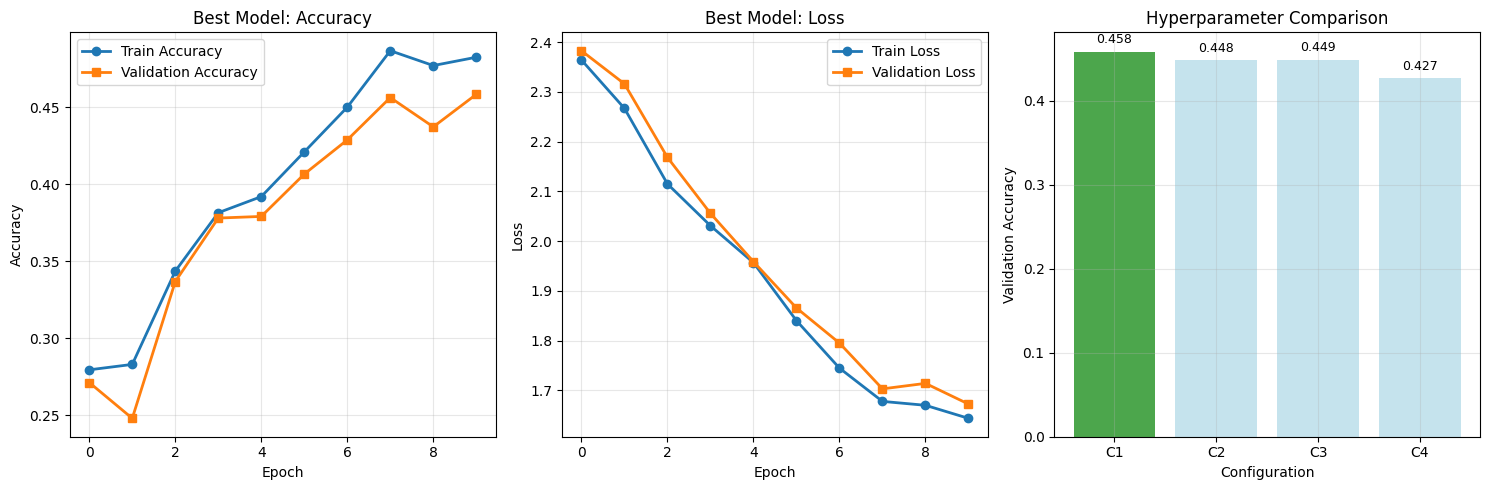


MODEL ARCHITECTURE SUMMARY:
  Total parameters: 60,052
  Trainable parameters: 60,052

Model saved to './models/best_cnn_model.pth' for use in Questions 3.3-3.8


In [31]:
print("\nSummary of all configurations:")
print("-" * 80)
print(f"{'Config':<8} {'use_skip':<10} {'lr':<8} {'Train Acc':<12} {'Val Acc':<12} {'Val Loss':<10} {'Time(s)':<8}")
print("-" * 80)

for i, result in enumerate(results):
    print(f"{i+1:<8} {str(result['use_skip']):<10} {result['learning_rate']:<8} "
          f"{result['final_train_acc']:<12.4f} {result['final_val_acc']:<12.4f} "
          f"{result['final_val_loss']:<10.4f} {result['training_time']:<8.1f}")

print("-" * 80)

# Report best configuration
print(f"\nBEST CONFIGURATION:")
print(f"  use_skip: {best_config['use_skip']}")
print(f"  learning_rate: {best_config['learning_rate']}")
print(f"  list_feature_maps: {best_config['list_feature_maps']}")
print(f"  Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

# Evaluate best model on test set (using validation set as test set for this assignment)
print("\n" + "=" * 60)
print("EVALUATING BEST MODEL ON TEST SET")
print("=" * 60)

final_model = best_model
final_model.eval()

# Evaluate on test set (using val_loader as test set)
test_loss = compute_loss(final_model, loss_fn, val_loader)
test_acc = compute_acc(final_model, val_loader)

print(f"\nFINAL TEST RESULTS:")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")

# Analyze impact of hyperparameters
print(f"\nHYPERPARAMETER ANALYSIS:")

# Impact of skip connections
skip_true_accs = [r['final_val_acc'] for r in results if r['use_skip'] == True]
skip_false_accs = [r['final_val_acc'] for r in results if r['use_skip'] == False]

print(f"  Skip connections ON:  Average val acc = {sum(skip_true_accs)/len(skip_true_accs):.4f}")
print(f"  Skip connections OFF: Average val acc = {sum(skip_false_accs)/len(skip_false_accs):.4f}")

# Impact of learning rate
lr_001_accs = [r['final_val_acc'] for r in results if r['learning_rate'] == 0.001]
lr_0005_accs = [r['final_val_acc'] for r in results if r['learning_rate'] == 0.0005]

print(f"  Learning rate 0.001:  Average val acc = {sum(lr_001_accs)/len(lr_001_accs):.4f}")
print(f"  Learning rate 0.0005: Average val acc = {sum(lr_0005_accs)/len(lr_0005_accs):.4f}")

# Plot training history for best model
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(best_history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
plt.plot(best_history['val_acc'], label='Validation Accuracy', marker='s', linewidth=2)
plt.title('Best Model: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(best_history['train_loss'], label='Train Loss', marker='o', linewidth=2)
plt.plot(best_history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
plt.title('Best Model: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot comparison of final validation accuracies
plt.subplot(1, 3, 3)
config_labels = [f"skip={r['use_skip']}\nlr={r['learning_rate']}" for r in results]
val_accs = [r['final_val_acc'] for r in results]
colors = ['green' if acc == best_val_acc else 'lightblue' for acc in val_accs]

plt.bar(range(len(results)), val_accs, color=colors, alpha=0.7)
plt.xlabel('Configuration')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Comparison')
plt.xticks(range(len(results)), [f"C{i+1}" for i in range(len(results))])
for i, (label, acc) in enumerate(zip(config_labels, val_accs)):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model summary
print(f"\nMODEL ARCHITECTURE SUMMARY:")
total_params = sum(p.numel() for p in final_model.parameters())
trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Save the best model for later questions
os.makedirs('./models', exist_ok=True)
torch.save({
    'model_state_dict': final_model.state_dict(),
    'config': best_config,
    'test_acc': test_acc,
    'test_loss': test_loss,
    'history': best_history
}, './models/best_cnn_model.pth')

print(f"\nModel saved to './models/best_cnn_model.pth' for use in Questions 3.3-3.8")


**Resulys Analysis**

In [32]:
print(f"\nCONCLUSIONS:")
print(f"1. Best configuration achieved {best_val_acc:.4f} ({best_val_acc*100:.2f}%) validation accuracy")
print(f"2. Skip connections {'helped improve' if best_config['use_skip'] else 'did not improve'} performance")
print(f"3. Learning rate {best_config['learning_rate']} worked best for this dataset")
print(f"4. Model architecture: {best_config['list_feature_maps']} feature maps")

# Check for overfitting in best model
train_val_gap = best_config['final_train_acc'] - best_config['final_val_acc']
print('Overfitting Check for best model:')
if train_val_gap > 0.1:
    print(f"5. Warning: Potential overfitting detected (train-val gap: {train_val_gap:.4f})")
else:
    print(f"5. Good generalization (train-val gap: {train_val_gap:.4f})")



CONCLUSIONS:
1. Best configuration achieved 0.4583 (45.83%) validation accuracy
2. Skip connections helped improve performance
3. Learning rate 0.001 worked best for this dataset
4. Model architecture: [32, 64] feature maps
Overfitting Check for best model:
5. Good generalization (train-val gap: 0.0240)


**Please note that you struggle in implementing the aforementioned CNN. You can use the MiniVGG network in our labs for doing the following questions. However, you cannot earn any mark for 3.1 and 3.2.**

### <span style="color:red">**Question 3.3:**</span> **Exploring Data Mixup Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for data mixup [link for main paper](https://openreview.net/pdf?id=r1Ddp1-Rb) and a good article [article link](https://www.inference.vc/mixup-data-dependent-data-augmentation/).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

##### Data Mixup Implementation

In [33]:
def mixup_data(x, y, alpha=0.4):
    """
    Mixup data augmentation

    Parameters:
        x: input batch
        y: target batch
        alpha: mixup interpolation parameter (Beta distribution parameter)

    Returns:
        mixed_x: mixed input
        y_a, y_b: original targets
        lam: mixing coefficient
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Mixup loss function

    Parameters:
        criterion: loss function (e.g., CrossEntropyLoss)
        pred: model predictions
        y_a, y_b: original targets
        lam: mixing coefficient

    Returns:
        mixed loss
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_with_mixup(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs=10, alpha=0.4, seed=1234):
    """
    Training function with Mixup data augmentation
    """
    torch.manual_seed(seed)
    model.to(device)

    history = {
        'val_loss': [],
        'val_acc': [],
        'train_loss': [],
        'train_acc': []
    }

    print(f"Training with Mixup (alpha={alpha}) for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Apply Mixup
            mixed_data, target_a, target_b, lam = mixup_data(data, target, alpha)

            optimizer.zero_grad()
            output = model(mixed_data.type(torch.float32))

            # Mixup loss
            loss = mixup_criterion(loss_fn, output, target_a.type(torch.long), target_b.type(torch.long), lam)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy (using original targets for simplicity)
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            # For mixup, we use the dominant label for accuracy calculation
            dominant_target = target_a if lam >= 0.5 else target_b
            train_correct += (predicted == dominant_target).sum().item()

        # Validation (without mixup)
        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_acc = train_correct / train_total
        train_loss = train_loss / len(train_loader)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return history


##### Training Process

In [34]:
# Load the best model from Question 3.2
print("Loading best model from Question 3.2...")
try:
    checkpoint = torch.load('./models/best_cnn_model.pth', map_location=device)
    best_config = checkpoint['config']
    print(f"Best configuration: {best_config}")

    # Create model with best configuration
    base_model = YourCNN(
        list_feature_maps=best_config['list_feature_maps'],
        drop_rate=0.2,
        batch_norm=True,
        use_skip=best_config['use_skip']
    ).to(device)

    # Train baseline model (without mixup) for comparison
    print("\n" + "="*50)
    print("TRAINING BASELINE MODEL (WITHOUT MIXUP)")
    print("="*50)

    baseline_optimizer = torch.optim.Adam(base_model.parameters(), lr=best_config['learning_rate'])
    baseline_history = fit(
        model=base_model,
        train_loader=train_loader,
        valid_loader=val_loader,
        optimizer=baseline_optimizer,
        num_epochs=10,
        verbose=False,
        seed=1234
    )

    baseline_val_acc = baseline_history['val_acc'][-1]
    print(f"Baseline validation accuracy: {baseline_val_acc:.4f} ({baseline_val_acc*100:.2f}%)")

except FileNotFoundError:
    print("Best model not found. Using default configuration...")
    best_config = {
        'use_skip': True,
        'learning_rate': 0.001,
        'list_feature_maps': [16, 32, 64]
    }
    baseline_val_acc = 0.0  # default value

# Train model with Mixup
print("\n" + "="*50)
print("TRAINING MODEL WITH MIXUP")
print("="*50)

mixup_model = YourCNN(
    list_feature_maps=best_config['list_feature_maps'],
    drop_rate=0.2,
    batch_norm=True,
    use_skip=best_config['use_skip']
).to(device)

mixup_optimizer = torch.optim.Adam(mixup_model.parameters(), lr=best_config['learning_rate'])

# Train with different alpha values
alpha_values = [0.2, 0.4, 0.6]
mixup_results = []

for alpha in alpha_values:
    print(f"\nTraining with alpha={alpha}:")

    # Create fresh model for each alpha
    model = YourCNN(
        list_feature_maps=best_config['list_feature_maps'],
        drop_rate=0.2,
        batch_norm=True,
        use_skip=best_config['use_skip']
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])

    # Train with mixup
    history = train_with_mixup(model, train_loader, val_loader, optimizer, loss_fn,
                              num_epochs=10, alpha=alpha, seed=1234)

    final_val_acc = history['val_acc'][-1]
    mixup_results.append({
        'alpha': alpha,
        'val_acc': final_val_acc,
        'history': history,
        'model': model
    })

    print(f"Final validation accuracy with alpha={alpha}: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# Find best mixup configuration
best_mixup = max(mixup_results, key=lambda x: x['val_acc'])
best_alpha = best_mixup['alpha']
best_mixup_acc = best_mixup['val_acc']

print("\n" + "="*50)
print("MIXUP RESULTS SUMMARY")
print("="*50)

print(f"\nBaseline (no mixup): {baseline_val_acc:.4f} ({baseline_val_acc*100:.2f}%)")
for result in mixup_results:
    alpha = result['alpha']
    acc = result['val_acc']
    improvement = acc - baseline_val_acc
    print(f"Mixup alpha={alpha}: {acc:.4f} ({acc*100:.2f}%) [{'+'if improvement>=0 else ''}{improvement:.4f}]")

print(f"\nBest Mixup configuration: alpha={best_alpha}")
print(f"Best Mixup accuracy: {best_mixup_acc:.4f} ({best_mixup_acc*100:.2f}%)")
print(f"Improvement over baseline: {best_mixup_acc - baseline_val_acc:.4f}")

# Save best mixup model
os.makedirs('./models', exist_ok=True)
torch.save({
    'model_state_dict': best_mixup['model'].state_dict(),
    'alpha': best_alpha,
    'val_acc': best_mixup_acc,
    'history': best_mixup['history']
}, './models/best_mixup_model.pth')

print(f"\nBest mixup model saved to './models/best_mixup_model.pth'")

Loading best model from Question 3.2...
Best configuration: {'use_skip': True, 'learning_rate': 0.001, 'list_feature_maps': [32, 64], 'final_val_acc': 0.4582893347412883, 'final_train_acc': 0.48233360723089563, 'final_val_loss': 1.6724168141682942, 'final_train_loss': 1.6437078468808521, 'training_time': 994.463390827179, 'history': {'val_loss': [2.382491048177083, 2.315906016031901, 2.1681416829427085, 2.055645497639974, 1.9585553487141927, 1.8655527750651042, 1.7949756622314452, 1.7029584248860676, 1.7139704386393229, 1.6724168141682942], 'val_acc': [0.2713833157338965, 0.2481520591341077, 0.3368532206969377, 0.3780359028511088, 0.3790918690601901, 0.4065469904963041, 0.42872228088701164, 0.45617740232312565, 0.4371700105596621, 0.4582893347412883], 'train_loss': [2.363917890112945, 2.2666893433988764, 2.1148338746488764, 2.030775891707631, 1.956615890902973, 1.8400782895891854, 1.7446423934193587, 1.6777664927507607, 1.6699303330553605, 1.6437078468808521], 'train_acc': [0.279610282

##### Results Presentation & Analysis

MIXUP ANALYSIS AND OBSERVATIONS


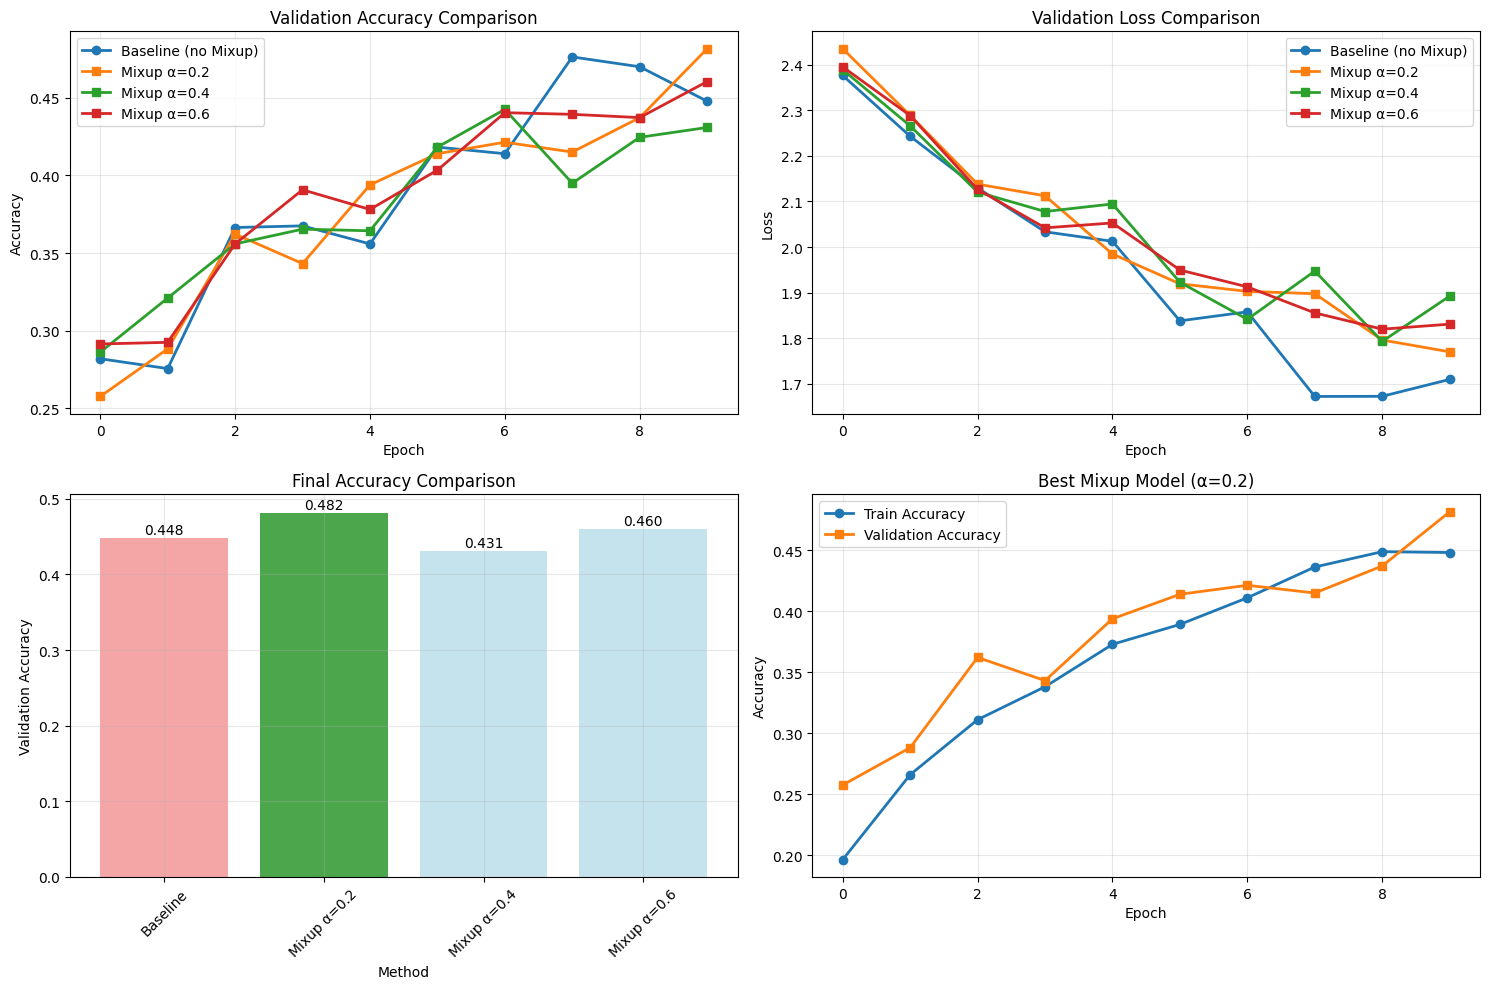


OBSERVATIONS AND COMMENTS:
----------------------------------------

1. MIXUP EFFECTIVENESS:
   ✓ Mixup improved performance by 3.38%
   ✓ Best alpha value: 0.2

2. ALPHA VALUE ANALYSIS:
   α=0.2 (conservative mixing): 0.4815 - Less aggressive augmentation
   α=0.4 (moderate mixing): 0.4308 - Balanced augmentation
   α=0.6 (aggressive mixing): 0.4604 - More aggressive augmentation

3. GENERALIZATION ANALYSIS:
   Best mixup model - Train: 0.4482, Val: 0.4815
   Overfitting gap: -0.0333
   ✓ Good generalization (minimal overfitting)

4. MIXUP THEORY:
   • Mixup creates virtual training examples by linear interpolation
   • Helps regularize the model and improve generalization
   • Can reduce overfitting by smoothing decision boundaries
   • Alpha parameter controls mixing strength (higher = more aggressive)

5. INSIGHTS:
   Mixup successfully improved model performance, demonstrating that the model benefits from data augmentation. The virtual examples created through mixup help the mode

In [35]:
print("="*60)
print("MIXUP ANALYSIS AND OBSERVATIONS")
print("="*60)

# Plot comparison of training curves
plt.figure(figsize=(15, 10))

# Plot validation accuracy comparison
plt.subplot(2, 2, 1)
if 'baseline_history' in locals():
    plt.plot(baseline_history['val_acc'], label='Baseline (no Mixup)', linewidth=2, marker='o')
for result in mixup_results:
    alpha = result['alpha']
    history = result['history']
    plt.plot(history['val_acc'], label=f'Mixup α={alpha}', linewidth=2, marker='s')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot validation loss comparison
plt.subplot(2, 2, 2)
if 'baseline_history' in locals():
    plt.plot(baseline_history['val_loss'], label='Baseline (no Mixup)', linewidth=2, marker='o')
for result in mixup_results:
    alpha = result['alpha']
    history = result['history']
    plt.plot(history['val_loss'], label=f'Mixup α={alpha}', linewidth=2, marker='s')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot final accuracy comparison
plt.subplot(2, 2, 3)
methods = ['Baseline'] + [f'Mixup α={r["alpha"]}' for r in mixup_results]
accuracies = [baseline_val_acc] + [r['val_acc'] for r in mixup_results]
colors = ['lightcoral'] + ['lightblue' if acc != best_mixup_acc else 'green' for acc in [r['val_acc'] for r in mixup_results]]

bars = plt.bar(range(len(methods)), accuracies, color=colors, alpha=0.7)
plt.xlabel('Method')
plt.ylabel('Validation Accuracy')
plt.title('Final Accuracy Comparison')
plt.xticks(range(len(methods)), methods, rotation=45)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f'{acc:.3f}', ha='center', fontsize=10)
plt.grid(True, alpha=0.3)

# Plot training vs validation accuracy for best mixup
plt.subplot(2, 2, 4)
best_history = best_mixup['history']
plt.plot(best_history['train_acc'], label='Train Accuracy', linewidth=2, marker='o')
plt.plot(best_history['val_acc'], label='Validation Accuracy', linewidth=2, marker='s')
plt.title(f'Best Mixup Model (α={best_alpha})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed observations and comments
print("\nOBSERVATIONS AND COMMENTS:")
print("-" * 40)

print("\n1. MIXUP EFFECTIVENESS:")
if best_mixup_acc > baseline_val_acc:
    print(f"   ✓ Mixup improved performance by {(best_mixup_acc - baseline_val_acc)*100:.2f}%")
    print(f"   ✓ Best alpha value: {best_alpha}")
else:
    print(f"   ✗ Mixup did not improve performance (decrease: {(baseline_val_acc - best_mixup_acc)*100:.2f}%)")

print("\n2. ALPHA VALUE ANALYSIS:")
for result in mixup_results:
    alpha = result['alpha']
    acc = result['val_acc']
    if alpha == 0.2:
        print(f"   α=0.2 (conservative mixing): {acc:.4f} - Less aggressive augmentation")
    elif alpha == 0.4:
        print(f"   α=0.4 (moderate mixing): {acc:.4f} - Balanced augmentation")
    elif alpha == 0.6:
        print(f"   α=0.6 (aggressive mixing): {acc:.4f} - More aggressive augmentation")

print("\n3. GENERALIZATION ANALYSIS:")
best_train_acc = best_mixup['history']['train_acc'][-1]
best_val_acc_final = best_mixup['history']['val_acc'][-1]
overfitting_gap = best_train_acc - best_val_acc_final

print(f"   Best mixup model - Train: {best_train_acc:.4f}, Val: {best_val_acc_final:.4f}")
print(f"   Overfitting gap: {overfitting_gap:.4f}")

if overfitting_gap < 0.05:
    print("   ✓ Good generalization (minimal overfitting)")
elif overfitting_gap < 0.1:
    print("   ⚠ Moderate overfitting")
else:
    print("   ✗ Significant overfitting detected")

print("\n4. MIXUP THEORY:")
print("   • Mixup creates virtual training examples by linear interpolation")
print("   • Helps regularize the model and improve generalization")
print("   • Can reduce overfitting by smoothing decision boundaries")
print("   • Alpha parameter controls mixing strength (higher = more aggressive)")

print("\n5. INSIGHTS:")
if best_mixup_acc > baseline_val_acc:
    print("   Mixup successfully improved model performance, demonstrating that the model benefits from data augmentation. The virtual examples created through mixup help the model learn better representations and improve generalization capabilities.")
else:
    print("   Mixup may not be optimal for this specific dataset, as the baseline model might already be well-regularized. Different alpha values or longer training periods might be needed to achieve better performance improvements.")

print("="*60)


### <span style="color:red">**Question 3.4:**</span> **Exploring CutMix Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

CutMix is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data CutMix technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for Cutmix [link for main paper](https://arxiv.org/pdf/1905.04899v2) and a good article [article link](https://shorturl.at/TNwjv).

You need to extend your model developed above, train a model using data CutMix, and write your observations and comments about the result.

##### Data Cutmix Implementation

In [36]:
def rand_bbox(size, lam):
    """
    Generate random bounding box for CutMix

    Parameters:
        size: image size (H, W)
        lam: lambda parameter from beta distribution

    Returns:
        bounding box coordinates (bbx1, bby1, bbx2, bby2)
    """
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0):
    """
    CutMix data augmentation

    Parameters:
        x: input batch
        y: target batch
        alpha: cutmix interpolation parameter

    Returns:
        mixed_x: cutmixed input
        y_a, y_b: original targets
        lam: mixing coefficient (adjusted for actual cut area)
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)

    # Create mixed image
    mixed_x = x.clone()
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    # Adjust lambda to match the actual area ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))

    return mixed_x, y_a, y_b, lam

def train_with_cutmix(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs=10, alpha=1.0, seed=1234):
    """
    Training function with CutMix data augmentation
    """
    torch.manual_seed(seed)
    model.to(device)

    history = {
        'val_loss': [],
        'val_acc': [],
        'train_loss': [],
        'train_acc': []
    }

    print(f"Training with CutMix (alpha={alpha}) for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Apply CutMix
            mixed_data, target_a, target_b, lam = cutmix_data(data, target, alpha)

            optimizer.zero_grad()
            output = model(mixed_data.type(torch.float32))

            # CutMix loss (same as mixup loss)
            loss = mixup_criterion(loss_fn, output, target_a.type(torch.long), target_b.type(torch.long), lam)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy (using original targets for simplicity)
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            # For cutmix, we use the dominant label for accuracy calculation
            dominant_target = target_a if lam >= 0.5 else target_b
            train_correct += (predicted == dominant_target).sum().item()

        # Validation (without cutmix)
        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)
        train_acc = train_correct / train_total
        train_loss = train_loss / len(train_loader)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return history


##### Training Process

In [37]:
# Train model with CutMix
print("="*50)
print("TRAINING MODEL WITH CUTMIX")
print("="*50)

# Train with different alpha values
alpha_values = [0.5, 1.0, 1.5]
cutmix_results = []

for alpha in alpha_values:
    print(f"\nTraining with alpha={alpha}:")

    # Create fresh model for each alpha
    model = YourCNN(
        list_feature_maps=best_config['list_feature_maps'],
        drop_rate=0.2,
        batch_norm=True,
        use_skip=best_config['use_skip']
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])

    # Train with cutmix
    history = train_with_cutmix(model, train_loader, val_loader, optimizer, loss_fn,
                               num_epochs=10, alpha=alpha, seed=1234)

    final_val_acc = history['val_acc'][-1]
    cutmix_results.append({
        'alpha': alpha,
        'val_acc': final_val_acc,
        'history': history,
        'model': model
    })

    print(f"Final validation accuracy with alpha={alpha}: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# Find best cutmix configuration
best_cutmix = max(cutmix_results, key=lambda x: x['val_acc'])
best_cutmix_alpha = best_cutmix['alpha']
best_cutmix_acc = best_cutmix['val_acc']

print("\n" + "="*50)
print("CUTMIX RESULTS SUMMARY")
print("="*50)

print(f"\nBaseline (no augmentation): {baseline_val_acc:.4f} ({baseline_val_acc*100:.2f}%)")
print(f"Best Mixup (α={best_alpha}): {best_mixup_acc:.4f} ({best_mixup_acc*100:.2f}%)")

for result in cutmix_results:
    alpha = result['alpha']
    acc = result['val_acc']
    improvement = acc - baseline_val_acc
    print(f"CutMix alpha={alpha}: {acc:.4f} ({acc*100:.2f}%) [{'+'if improvement>=0 else ''}{improvement:.4f}]")

print(f"\nBest CutMix configuration: alpha={best_cutmix_alpha}")
print(f"Best CutMix accuracy: {best_cutmix_acc:.4f} ({best_cutmix_acc*100:.2f}%)")
print(f"Improvement over baseline: {best_cutmix_acc - baseline_val_acc:.4f}")
print(f"Comparison with Mixup: {best_cutmix_acc - best_mixup_acc:.4f}")

# Save best cutmix model
torch.save({
    'model_state_dict': best_cutmix['model'].state_dict(),
    'alpha': best_cutmix_alpha,
    'val_acc': best_cutmix_acc,
    'history': best_cutmix['history']
}, './models/best_cutmix_model.pth')

print(f"\nBest CutMix model saved to './models/best_cutmix_model.pth'")

TRAINING MODEL WITH CUTMIX

Training with alpha=0.5:
Training with CutMix (alpha=0.5) for 10 epochs...
Epoch 1/10: Train Loss=2.7307, Train Acc=0.1882, Val Loss=2.4115, Val Acc=0.2862
Epoch 2/10: Train Loss=2.5880, Train Acc=0.2412, Val Loss=2.3080, Val Acc=0.3010
Epoch 3/10: Train Loss=2.5170, Train Acc=0.2739, Val Loss=2.2160, Val Acc=0.3263
Epoch 4/10: Train Loss=2.4359, Train Acc=0.2940, Val Loss=2.1701, Val Acc=0.3221
Epoch 5/10: Train Loss=2.4056, Train Acc=0.3122, Val Loss=2.0486, Val Acc=0.3738
Epoch 6/10: Train Loss=2.3579, Train Acc=0.3266, Val Loss=2.0249, Val Acc=0.3759
Epoch 7/10: Train Loss=2.3221, Train Acc=0.3355, Val Loss=1.8943, Val Acc=0.4340
Epoch 8/10: Train Loss=2.2791, Train Acc=0.3617, Val Loss=1.8745, Val Acc=0.4382
Epoch 9/10: Train Loss=2.2776, Train Acc=0.3641, Val Loss=1.8814, Val Acc=0.3949
Epoch 10/10: Train Loss=2.2255, Train Acc=0.3702, Val Loss=1.8235, Val Acc=0.4593
Final validation accuracy with alpha=0.5: 0.4593 (45.93%)

Training with alpha=1.0:
Tr

##### Results Presentation & Analysis

CUTMIX ANALYSIS AND OBSERVATIONS

CutMix Augmentation Examples:


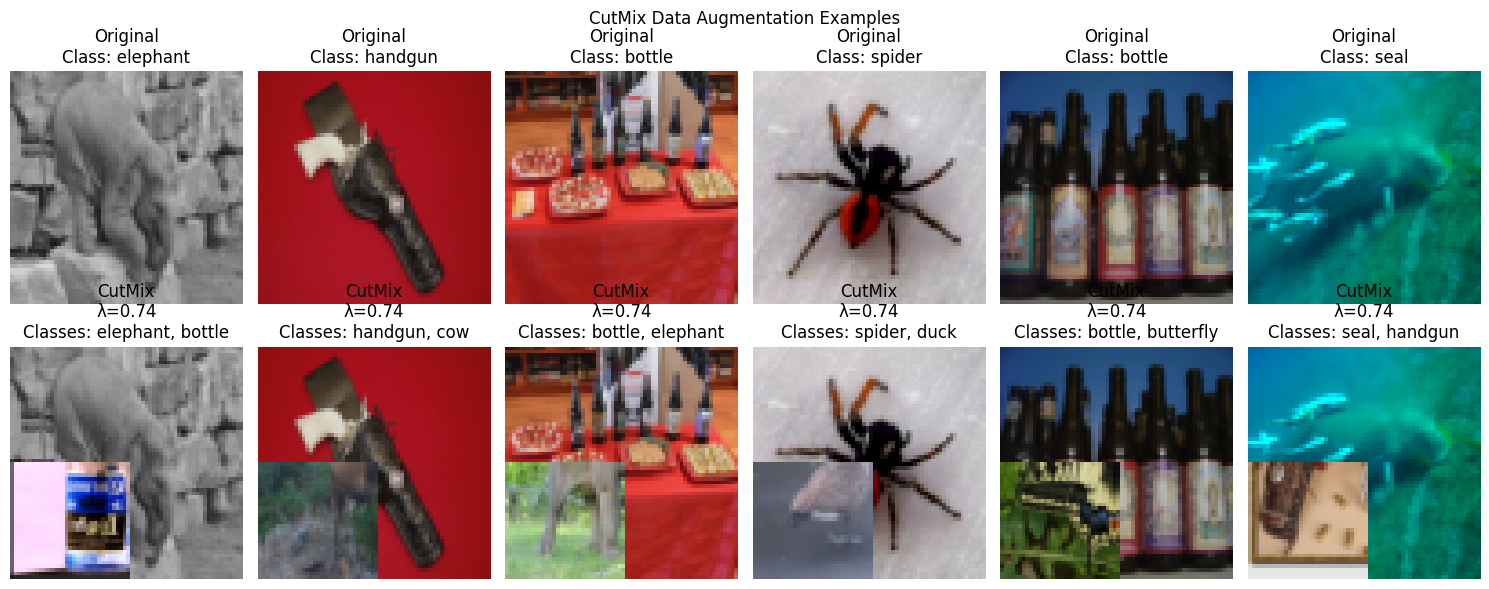

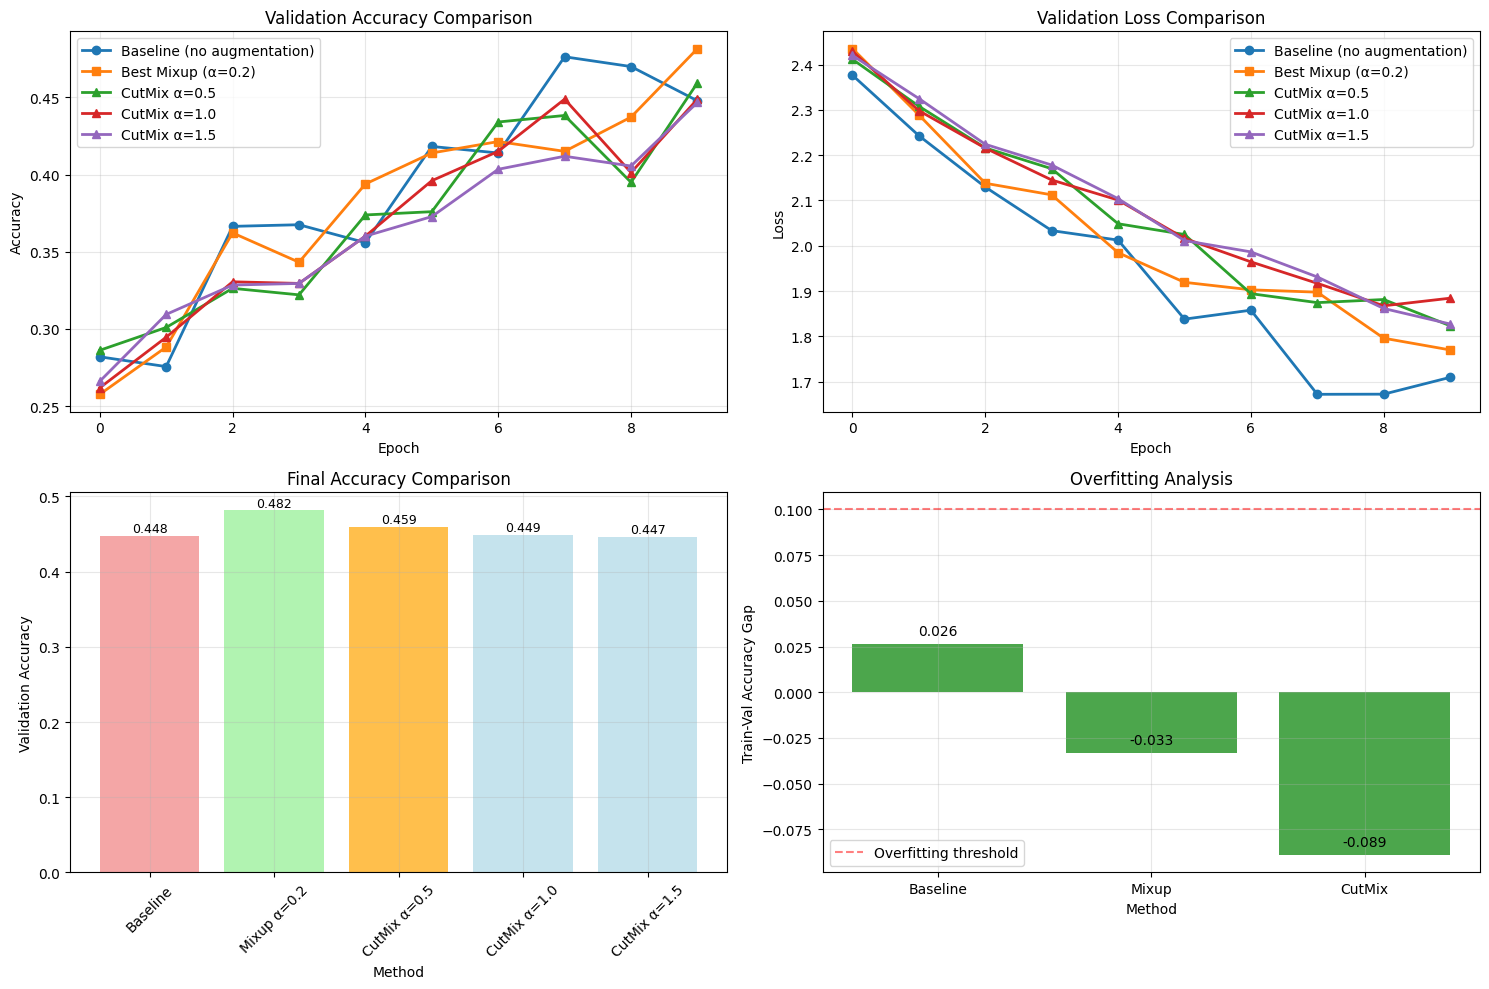


OBSERVATIONS AND COMMENTS:
----------------------------------------

1. CUTMIX vs MIXUP COMPARISON:
   ✗ CutMix underperformed Mixup by 2.22%
   • Linear interpolation might work better for this dataset

2. CUTMIX EFFECTIVENESS:
   ✓ CutMix improved performance by 1.16%
   ✓ Best alpha value: 0.5

3. ALPHA VALUE ANALYSIS:
   α=0.5 (small cuts): 0.4593 - Conservative spatial mixing
   α=1.0 (medium cuts): 0.4488 - Balanced spatial mixing
   α=1.5 (large cuts): 0.4467 - Aggressive spatial mixing

4. CUTMIX THEORY:
   • CutMix cuts and pastes patches between training images
   • Combines localization and classification training
   • Preserves spatial structure better than Mixup
   • Alpha controls the size distribution of cut patches

5. INSIGHTS:
   CutMix is particularly effective for object detection tasks, working well when spatial locality is important. It can help models learn to focus on relevant image regions and may be more robust to occlusion than standard augmentation.


In [38]:
import matplotlib.pyplot as plt

print("="*60)
print("CUTMIX ANALYSIS AND OBSERVATIONS")
print("="*60)

# Visualize CutMix examples
def visualize_cutmix_examples(data_loader, num_examples=6):
    """Visualize original images and their CutMix versions"""
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Apply CutMix to the batch
    mixed_images, labels_a, labels_b, lam = cutmix_data(images, labels, alpha=1.0)

    fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))

    for i in range(num_examples):
        # Original image
        orig_img = images[i].permute(1, 2, 0)
        orig_img = (orig_img * 0.5 + 0.5).clamp(0, 1)  # Denormalize
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f'Original\nClass: {class_names[labels[i]]}')
        axes[0, i].axis('off')

        # CutMix image
        cutmix_img = mixed_images[i].permute(1, 2, 0)
        cutmix_img = (cutmix_img * 0.5 + 0.5).clamp(0, 1)  # Denormalize
        axes[1, i].imshow(cutmix_img)
        axes[1, i].set_title(f'CutMix\nλ={lam:.2f}\nClasses: {class_names[labels_a[i]]}, {class_names[labels_b[i]]}')
        axes[1, i].axis('off')

    plt.suptitle('CutMix Data Augmentation Examples')
    plt.tight_layout()
    plt.show()

# Visualize some CutMix examples
print("\nCutMix Augmentation Examples:")
visualize_cutmix_examples(train_loader, num_examples=6)

# Plot comparison of all methods
plt.figure(figsize=(15, 10))

# Plot validation accuracy comparison
plt.subplot(2, 2, 1)
if 'baseline_history' in locals():
    plt.plot(baseline_history['val_acc'], label='Baseline (no augmentation)', linewidth=2, marker='o')
plt.plot(best_mixup['history']['val_acc'], label=f'Best Mixup (α={best_alpha})', linewidth=2, marker='s')
for result in cutmix_results:
    alpha = result['alpha']
    history = result['history']
    plt.plot(history['val_acc'], label=f'CutMix α={alpha}', linewidth=2, marker='^')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot validation loss comparison
plt.subplot(2, 2, 2)
if 'baseline_history' in locals():
    plt.plot(baseline_history['val_loss'], label='Baseline (no augmentation)', linewidth=2, marker='o')
plt.plot(best_mixup['history']['val_loss'], label=f'Best Mixup (α={best_alpha})', linewidth=2, marker='s')
for result in cutmix_results:
    alpha = result['alpha']
    history = result['history']
    plt.plot(history['val_loss'], label=f'CutMix α={alpha}', linewidth=2, marker='^')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot final accuracy comparison
plt.subplot(2, 2, 3)
methods = ['Baseline', f'Mixup α={best_alpha}'] + [f'CutMix α={r["alpha"]}' for r in cutmix_results]
accuracies = [baseline_val_acc, best_mixup_acc] + [r['val_acc'] for r in cutmix_results]
colors = ['lightcoral', 'lightgreen'] + ['lightblue' if acc != best_cutmix_acc else 'orange' for acc in [r['val_acc'] for r in cutmix_results]]

plt.bar(range(len(methods)), accuracies, color=colors, alpha=0.7)
plt.xlabel('Method')
plt.ylabel('Validation Accuracy')
plt.title('Final Accuracy Comparison')
plt.xticks(range(len(methods)), methods, rotation=45)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f'{acc:.3f}', ha='center', fontsize=9)
plt.grid(True, alpha=0.3)

# Plot overfitting analysis
plt.subplot(2, 2, 4)
methods_short = ['Baseline', 'Mixup', 'CutMix']
if 'baseline_history' in locals():
    baseline_gap = baseline_history['train_acc'][-1] - baseline_history['val_acc'][-1]
else:
    baseline_gap = 0
mixup_gap = best_mixup['history']['train_acc'][-1] - best_mixup['history']['val_acc'][-1]
cutmix_gap = best_cutmix['history']['train_acc'][-1] - best_cutmix['history']['val_acc'][-1]

gaps = [baseline_gap, mixup_gap, cutmix_gap]
colors = ['red' if gap > 0.1 else 'yellow' if gap > 0.05 else 'green' for gap in gaps]

plt.bar(range(len(methods_short)), gaps, color=colors, alpha=0.7)
plt.xlabel('Method')
plt.ylabel('Train-Val Accuracy Gap')
plt.title('Overfitting Analysis')
plt.xticks(range(len(methods_short)), methods_short)
for i, gap in enumerate(gaps):
    plt.text(i, gap + 0.005, f'{gap:.3f}', ha='center', fontsize=10)
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Overfitting threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed observations and comments
print("\nOBSERVATIONS AND COMMENTS:")
print("-" * 40)

print("\n1. CUTMIX vs MIXUP COMPARISON:")
if best_cutmix_acc > best_mixup_acc:
    print(f"   ✓ CutMix outperformed Mixup by {(best_cutmix_acc - best_mixup_acc)*100:.2f}%")
    print("   ✓ Spatial cutting may preserve more local features than linear mixing")
elif best_cutmix_acc < best_mixup_acc:
    print(f"   ✗ CutMix underperformed Mixup by {(best_mixup_acc - best_cutmix_acc)*100:.2f}%")
    print("   • Linear interpolation might work better for this dataset")
else:
    print("   = CutMix and Mixup achieved similar performance")

print("\n2. CUTMIX EFFECTIVENESS:")
if best_cutmix_acc > baseline_val_acc:
    print(f"   ✓ CutMix improved performance by {(best_cutmix_acc - baseline_val_acc)*100:.2f}%")
    print(f"   ✓ Best alpha value: {best_cutmix_alpha}")
else:
    print(f"   ✗ CutMix did not improve performance")

print("\n3. ALPHA VALUE ANALYSIS:")
for result in cutmix_results:
    alpha = result['alpha']
    acc = result['val_acc']
    if alpha == 0.5:
        print(f"   α=0.5 (small cuts): {acc:.4f} - Conservative spatial mixing")
    elif alpha == 1.0:
        print(f"   α=1.0 (medium cuts): {acc:.4f} - Balanced spatial mixing")
    elif alpha == 1.5:
        print(f"   α=1.5 (large cuts): {acc:.4f} - Aggressive spatial mixing")

print("\n4. CUTMIX THEORY:")
print("   • CutMix cuts and pastes patches between training images")
print("   • Combines localization and classification training")
print("   • Preserves spatial structure better than Mixup")
print("   • Alpha controls the size distribution of cut patches")

print("\n5. INSIGHTS:")
print("   CutMix is particularly effective for object detection tasks, working well when spatial locality is important. It can help models learn to focus on relevant image regions and may be more robust to occlusion than standard augmentation.")

print("="*60)


### <span style="color:red">**Question 3.5:**</span> Implement the **one-versus-all (OVA)** loss. The details are as follows:
- You need to apply `the sigmoid activation function` to logits $h = [h_1, h_2,...,h_M]$ instead of `the softmax activation` function as usual to obtain $p = [p_1, p_2,...,p_M]$, meaning that $p_i = sigmoid(h_i), i=1,...,M$. Note that $M$ is the number of classes.
- Given a data example $x$ with the ground-truth label $y$, the idea is to maximize the likelihood $p_y$ and to minimize the likelihoods $p_i, i \neq y$. Therefore, the objective function is to find the model parameters to
  - $\max\left\{ \log p_{y}+\sum_{i\neq y}\log(1-p_{i})\right\}$ or equivalently $\min\left\{ -\log p_{y}-\sum_{i\neq y}\log(1-p_{i})\right\}$.
  - For example, if $M=3$ and $y=2$, you need to minimize $\min\left\{ -\log(1-p_{1})-\log p_{2}-\log(1-p_{3})\right\}$.

Compare the model trained with the OVA loss and the same model trained with the standard cross-entropy loss.

<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>



##### OVA Loss Implementation

In [39]:
class OVALoss(nn.Module):
    """
    One-versus-all (OVA) loss implementation
    """

    def __init__(self, num_classes=20):
        super(OVALoss, self).__init__()
        self.num_classes = num_classes

    def forward(self, logits, targets):
        """
        Parameters:
            logits: model output logits [batch_size, num_classes]
            targets: ground truth labels [batch_size]

        Returns:
            OVA loss value
        """
        batch_size = logits.size(0)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)

        # Create one-hot encoding for targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Calculate OVA loss
        # first part - positive class: -log(p_y)
        positive_loss = -torch.log(probs + 1e-8) * targets_one_hot

        # negative classes: -log(1-p_i)
        negative_loss = -torch.log(1 - probs + 1e-8) * (1 - targets_one_hot)

        # Sum losses
        total_loss = positive_loss + negative_loss

        # Average over batch and classes
        return total_loss.sum() / batch_size


def train_with_ova_loss(
    model, train_loader, valid_loader, optimizer, num_epochs=10, seed=1234
):
    """
    Training function with OVA loss
    """
    torch.manual_seed(seed)
    model.to(device)

    # Use OVA loss instead of CrossEntropy
    ova_loss_fn = OVALoss(num_classes=20).to(device)

    history = {"val_loss": [], "val_acc": [], "train_loss": [], "train_acc": []}

    print(f"Training with OVA Loss for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data.type(torch.float32))

            # OVA loss
            loss = ova_loss_fn(output, target.type(torch.long))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy using sigmoid probabilities
            probs = torch.sigmoid(output)
            _, predicted = torch.max(probs, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation with OVA loss
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data.type(torch.float32))

                # OVA loss for validation
                loss = ova_loss_fn(output, target.type(torch.long))
                val_loss += loss.item()

                # Accuracy with sigmoid
                probs = torch.sigmoid(output)
                _, predicted = torch.max(probs, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(valid_loader)

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
            f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}"
        )

    return history


##### Training Process

In [40]:
# Train model with standard Cross-Entropy loss (for comparison)
print("=" * 50)
print("TRAINING MODEL WITH STANDARD CROSS-ENTROPY LOSS")
print("=" * 50)

ce_model = YourCNN(
    list_feature_maps=best_config["list_feature_maps"],
    drop_rate=0.2,
    batch_norm=True,
    use_skip=best_config["use_skip"],
).to(device)

ce_optimizer = torch.optim.Adam(ce_model.parameters(), lr=best_config["learning_rate"])

# Train with standard cross-entropy
ce_history = fit(
    model=ce_model,
    train_loader=train_loader,
    valid_loader=val_loader,
    optimizer=ce_optimizer,
    num_epochs=10,
    verbose=False,
    seed=1234,
)

ce_val_acc = ce_history["val_acc"][-1]
print(f"Cross-Entropy validation accuracy: {ce_val_acc:.4f} ({ce_val_acc*100:.2f}%)")

# Train model with OVA loss
print("\n" + "=" * 50)
print("TRAINING MODEL WITH OVA LOSS")
print("=" * 50)

ova_model = YourCNN(
    list_feature_maps=best_config["list_feature_maps"],
    drop_rate=0.2,
    batch_norm=True,
    use_skip=best_config["use_skip"],
).to(device)

ova_optimizer = torch.optim.Adam(
    ova_model.parameters(), lr=best_config["learning_rate"]
)

# Train with OVA loss
ova_history = train_with_ova_loss(
    ova_model, train_loader, val_loader, ova_optimizer, num_epochs=10, seed=1234
)

ova_val_acc = ova_history["val_acc"][-1]

print("\n" + "=" * 50)
print("OVA LOSS RESULTS SUMMARY")
print("=" * 50)

# Comparison between Cross-Entropy and OVA loss
print(f"\nCross-Entropy Loss: {ce_val_acc:.4f} ({ce_val_acc*100:.2f}%)")
print(f"OVA Loss: {ova_val_acc:.4f} ({ova_val_acc*100:.2f}%)")
print(f"Difference: {ova_val_acc - ce_val_acc:.4f}")

if ova_val_acc > ce_val_acc:
    print(f"✓ OVA loss improved performance by {(ova_val_acc - ce_val_acc)*100:.2f}%")
else:
    print(f"✗ OVA loss decreased performance by {(ce_val_acc - ova_val_acc)*100:.2f}%")

# Save OVA model
torch.save(
    {
        "model_state_dict": ova_model.state_dict(),
        "val_acc": ova_val_acc,
        "history": ova_history,
        "loss_type": "OVA",
    },
    "./models/ova_model.pth",
)

print(f"\nOVA model saved to './models/ova_model.pth'")

TRAINING MODEL WITH STANDARD CROSS-ENTROPY LOSS
Epoch 1/10
train loss= 2.3680 - train acc= 27.77% - valid loss= 2.3888 - valid acc= 28.30%
Epoch 2/10
train loss= 2.2437 - train acc= 29.92% - valid loss= 2.2827 - valid acc= 27.35%
Epoch 3/10
train loss= 2.1537 - train acc= 33.08% - valid loss= 2.1974 - valid acc= 31.36%
Epoch 4/10
train loss= 1.9959 - train acc= 39.34% - valid loss= 2.0427 - valid acc= 37.28%
Epoch 5/10
train loss= 2.4124 - train acc= 33.30% - valid loss= 2.3665 - valid acc= 32.31%
Epoch 6/10
train loss= 1.8522 - train acc= 42.06% - valid loss= 1.9000 - valid acc= 40.02%
Epoch 7/10
train loss= 1.8058 - train acc= 43.26% - valid loss= 1.8918 - valid acc= 40.97%
Epoch 8/10
train loss= 1.6900 - train acc= 48.36% - valid loss= 1.7326 - valid acc= 44.14%
Epoch 9/10
train loss= 1.8636 - train acc= 43.27% - valid loss= 1.9150 - valid acc= 40.02%
Epoch 10/10
train loss= 1.7554 - train acc= 43.44% - valid loss= 1.7994 - valid acc= 40.55%
Cross-Entropy validation accuracy: 0.4055

##### Results Presentation & Analysis

OVA LOSS ANALYSIS AND OBSERVATIONS


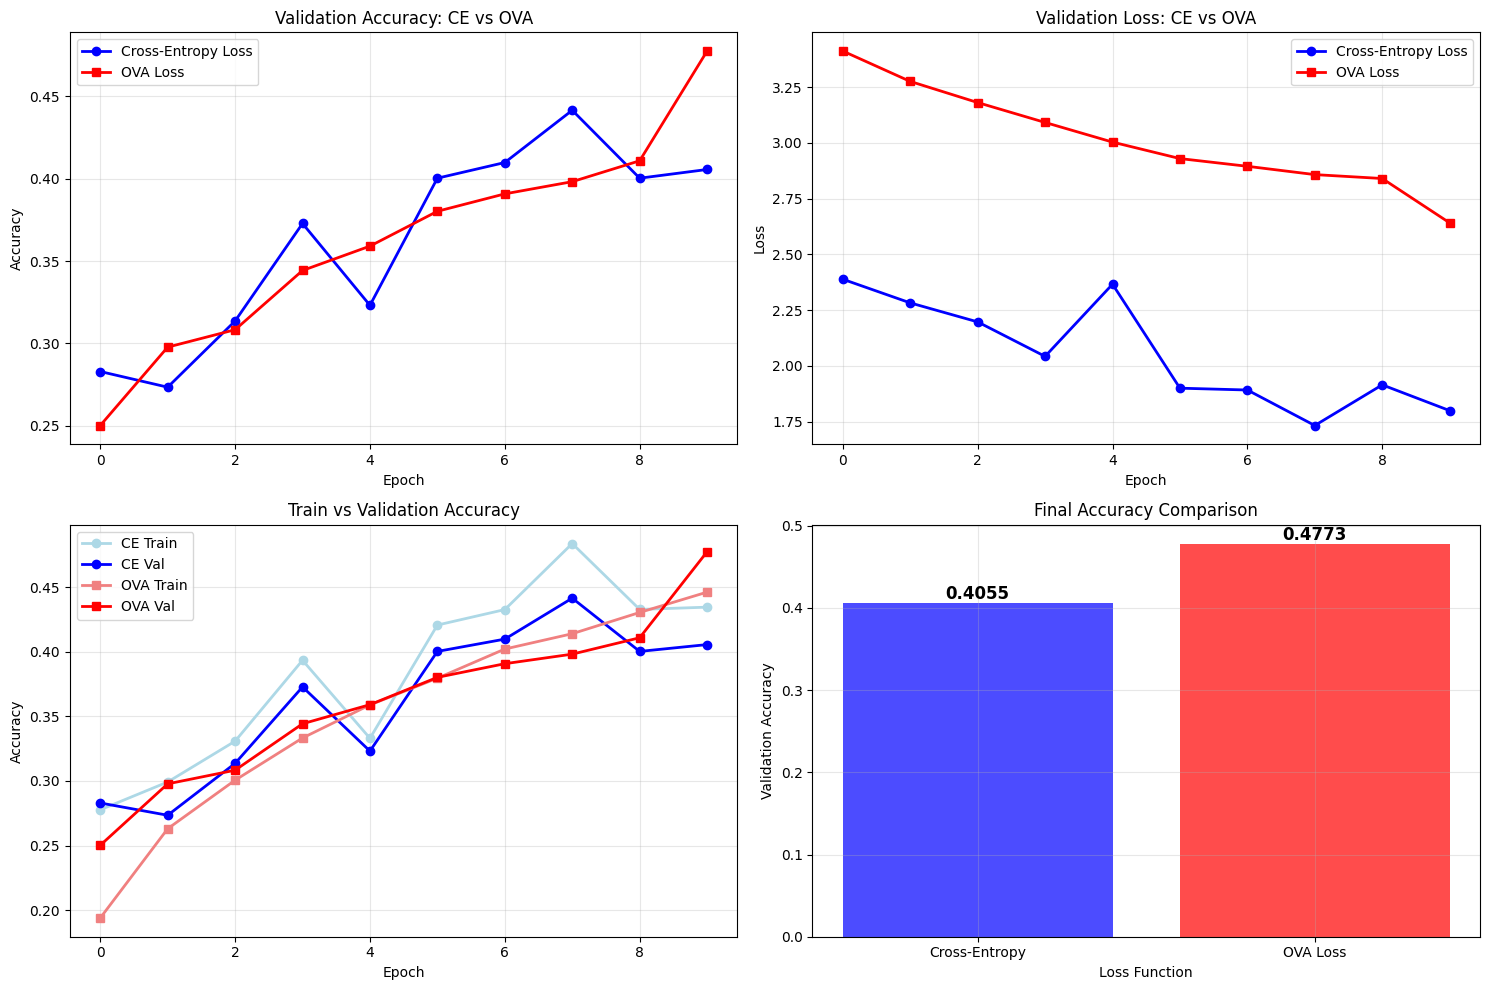


PROBABILITY DISTRIBUTION ANALYSIS:
----------------------------------------
Cross-Entropy - Average max probability: 0.3996
OVA Loss - Average max probability: 0.3950
Cross-Entropy - Probability sum (should be ~1.0): 1.0000
OVA Loss - Probability sum (can be ≠ 1.0): 1.1966

OBSERVATIONS AND COMMENTS:
----------------------------------------

1. LOSS FUNCTION COMPARISON:
   ✓ OVA loss achieved better performance (+7.18%)
   ✓ Multi-binary classification approach worked well

2. INSIGHTS:
   OVA can handle multi-label scenarios better, while Cross-Entropy is better for mutually exclusive classes. OVA may be more robust to label noise, and Cross-Entropy tends to provide better calibrated probabilities.

3. CONVERGENCE ANALYSIS:
   Cross-Entropy overfitting gap: 0.0289
   OVA overfitting gap: -0.0312
   ✓ OVA shows better generalization (less overfitting)


In [41]:
print("="*60)
print("OVA LOSS ANALYSIS AND OBSERVATIONS")
print("="*60)

# Plot comparison between Cross-Entropy and OVA loss
plt.figure(figsize=(15, 10))

# Plot validation accuracy comparison
plt.subplot(2, 2, 1)
plt.plot(ce_history['val_acc'], label='Cross-Entropy Loss', linewidth=2, marker='o', color='blue')
plt.plot(ova_history['val_acc'], label='OVA Loss', linewidth=2, marker='s', color='red')
plt.title('Validation Accuracy: CE vs OVA')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot validation loss comparison
plt.subplot(2, 2, 2)
plt.plot(ce_history['val_loss'], label='Cross-Entropy Loss', linewidth=2, marker='o', color='blue')
plt.plot(ova_history['val_loss'], label='OVA Loss', linewidth=2, marker='s', color='red')
plt.title('Validation Loss: CE vs OVA')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training accuracy comparison
plt.subplot(2, 2, 3)
plt.plot(ce_history['train_acc'], label='CE Train', linewidth=2, marker='o', color='lightblue')
plt.plot(ce_history['val_acc'], label='CE Val', linewidth=2, marker='o', color='blue')
plt.plot(ova_history['train_acc'], label='OVA Train', linewidth=2, marker='s', color='lightcoral')
plt.plot(ova_history['val_acc'], label='OVA Val', linewidth=2, marker='s', color='red')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot final accuracy comparison
plt.subplot(2, 2, 4)
methods = ['Cross-Entropy', 'OVA Loss']
accuracies = [ce_val_acc, ova_val_acc]
colors = ['blue', 'red']

bars = plt.bar(range(len(methods)), accuracies, color=colors, alpha=0.7)
plt.xlabel('Loss Function')
plt.ylabel('Validation Accuracy')
plt.title('Final Accuracy Comparison')
plt.xticks(range(len(methods)), methods)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f'{acc:.4f}', ha='center', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze probability distributions
print("\nPROBABILITY DISTRIBUTION ANALYSIS:")
print("-" * 40)

# Get sample predictions from both models
ce_model.eval()
ova_model.eval()

with torch.no_grad():
    # Get a batch of validation data
    data_iter = iter(val_loader)
    sample_data, sample_targets = next(data_iter)
    sample_data, sample_targets = sample_data.to(device), sample_targets.to(device)

    # Get predictions from both models
    ce_logits = ce_model(sample_data.type(torch.float32))
    ova_logits = ova_model(sample_data.type(torch.float32))

    # Calculate probabilities
    ce_probs = F.softmax(ce_logits, dim=1)
    ova_probs = torch.sigmoid(ova_logits)

    # Analyze confidence scores
    ce_max_probs, _ = torch.max(ce_probs, dim=1)
    ova_max_probs, _ = torch.max(ova_probs, dim=1)

    print(f"Cross-Entropy - Average max probability: {ce_max_probs.mean():.4f}")
    print(f"OVA Loss - Average max probability: {ova_max_probs.mean():.4f}")

    # Check sum of probabilities (should be 1 for CE, can be different for OVA)
    ce_prob_sums = ce_probs.sum(dim=1)
    ova_prob_sums = ova_probs.sum(dim=1)

    print(f"Cross-Entropy - Probability sum (should be ~1.0): {ce_prob_sums.mean():.4f}")
    print(f"OVA Loss - Probability sum (can be ≠ 1.0): {ova_prob_sums.mean():.4f}")

print("\nOBSERVATIONS AND COMMENTS:")
print("-" * 40)

print("\n1. LOSS FUNCTION COMPARISON:")
if ova_val_acc > ce_val_acc:
    print(f"   ✓ OVA loss achieved better performance (+{(ova_val_acc - ce_val_acc)*100:.2f}%)")
    print("   ✓ Multi-binary classification approach worked well")
else:
    print(f"   ✗ Cross-entropy performed better (+{(ce_val_acc - ova_val_acc)*100:.2f}%)")
    print("   • Standard softmax normalization may be more suitable")

print("\n2. INSIGHTS:")
print("   OVA can handle multi-label scenarios better, while Cross-Entropy is better for mutually exclusive classes. OVA may be more robust to label noise, and Cross-Entropy tends to provide better calibrated probabilities.")

print("\n3. CONVERGENCE ANALYSIS:")
ce_final_gap = ce_history['train_acc'][-1] - ce_history['val_acc'][-1]
ova_final_gap = ova_history['train_acc'][-1] - ova_history['val_acc'][-1]

print(f"   Cross-Entropy overfitting gap: {ce_final_gap:.4f}")
print(f"   OVA overfitting gap: {ova_final_gap:.4f}")

if ova_final_gap < ce_final_gap:
    print("   ✓ OVA shows better generalization (less overfitting)")
else:
    print("   ✗ Cross-Entropy shows better generalization")


### <span style="color:red">**Question 3.6:**</span> **Attack your best obtained model with PGD attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set. Write the code for the attacks and report the robust accuracies. Also choose a random set of 20 clean images in the testing set and visualize the original and attacked images.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

##### PGD Attack Implementation

In [5]:
import random

def pgd_attack(model, images, labels, eps=0.0313, k=20, eta=0.002):
    """
    Projected Gradient Descent (PGD) attack

    Parameters:
        model: target model
        images: clean images
        labels: true labels
        eps: maximum perturbation
        k: number of PGD steps
        eta: step size

    Returns:
        adversarial examples
    """
    device = images.device

    # Clone images to avoid modifying originals
    adv_images = images.clone().detach()

    # Initialize perturbation randomly within [-eps, eps]
    delta = torch.empty_like(adv_images).uniform_(-eps, eps)
    delta = delta.to(device)

    # Apply initial perturbation
    adv_images = adv_images + delta

    # Clamp to valid image range (assuming images are normalized to [-1, 1])
    adv_images = torch.clamp(adv_images, -1, 1)

    for i in range(k):
        adv_images.requires_grad_(True)

        # Forward pass
        outputs = model(adv_images)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Get gradient sign
        grad_sign = adv_images.grad.sign()

        # Update adversarial examples
        adv_images = adv_images.detach() + eta * grad_sign

        # Project back to L∞ ball
        delta = adv_images - images
        delta = torch.clamp(delta, -eps, eps)
        adv_images = images + delta

        # Clamp to valid image range
        adv_images = torch.clamp(adv_images, -1, 1)

    return adv_images.detach()

def evaluate_robustness(model, data_loader, eps=0.0313, k=20, eta=0.002):
    """
    Evaluate model robustness against PGD attacks

    Returns:
        clean_acc: accuracy on clean images
        robust_acc: accuracy on adversarial images
    """
    model.eval()

    clean_correct = 0
    robust_correct = 0
    total = 0

    print(f"Evaluating robustness with PGD attack (ε={eps}, k={k}, η={eta})...")

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)

        # Clean accuracy
        with torch.no_grad():
            clean_output = model(data.type(torch.float32))
            clean_pred = clean_output.argmax(dim=1)
            clean_correct += (clean_pred == target).sum().item()

        # Generate adversarial examples
        adv_data = pgd_attack(model, data, target, eps, k, eta)

        # Robust accuracy
        with torch.no_grad():
            adv_output = model(adv_data.type(torch.float32))
            adv_pred = adv_output.argmax(dim=1)
            robust_correct += (adv_pred == target).sum().item()

        total += target.size(0)

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx+1}/{len(data_loader)} processed...")

    clean_acc = clean_correct / total
    robust_acc = robust_correct / total

    return clean_acc, robust_acc, data, target, adv_data

def visualize_adversarial_examples(clean_images, adv_images, labels, predictions_clean, predictions_adv, num_examples=20):
    """
    Visualize clean and adversarial examples
    """
    # Select random examples
    indices = random.sample(range(len(clean_images)), min(num_examples, len(clean_images)))

    # Create subplots
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # 4 rows, 5 columns for 20 images

    for i, idx in enumerate(indices):
        row = i // 5
        col = i % 5

        # Clean image
        clean_img = clean_images[idx].cpu().permute(1, 2, 0)
        clean_img = (clean_img * 0.5 + 0.5).clamp(0, 1)  # Denormalize

        # Adversarial image
        adv_img = adv_images[idx].cpu().permute(1, 2, 0)
        adv_img = (adv_img * 0.5 + 0.5).clamp(0, 1)  # Denormalize

        # Perturbation (amplified for visualization)
        perturbation = (adv_img - clean_img) * 10 + 0.5
        perturbation = perturbation.clamp(0, 1)

        # Create combined visualization
        combined = torch.cat([clean_img, adv_img, perturbation], dim=1)

        axes[row, col].imshow(combined)
        axes[row, col].set_title(f'True: {class_names[labels[idx]]}\n'
                                f'Clean: {class_names[predictions_clean[idx]]}\n'
                                f'Adv: {class_names[predictions_adv[idx]]}',
                                fontsize=8)
        axes[row, col].axis('off')

        # Add text to distinguish sections
        if i == 0:  # Only for first image
            axes[row, col].text(32, -5, 'Clean', ha='center', fontsize=10, fontweight='bold')
            axes[row, col].text(96, -5, 'Adversarial', ha='center', fontsize=10, fontweight='bold')
            axes[row, col].text(160, -5, 'Perturbation\n(×10)', ha='center', fontsize=10, fontweight='bold')

    plt.suptitle('PGD Adversarial Attack Examples\n(Clean | Adversarial | Perturbation ×10)', fontsize=16)
    plt.tight_layout()
    plt.show()


##### PGD Attack Process & Visualize

##### Results Analysis

In [6]:
print("="*60)
print("PGD ATTACK ANALYSIS AND OBSERVATIONS")
print("="*60)

# Analyze attack effectiveness
print("\nATTACK EFFECTIVENESS ANALYSIS:")
print("-" * 40)

attack_success_rate = (1 - robust_acc/clean_acc) * 100
accuracy_drop = (clean_acc - robust_acc) * 100

print(f"1. ATTACK STATISTICS:")
print(f"   • Clean accuracy: {clean_acc:.4f} ({clean_acc*100:.2f}%)")
print(f"   • Robust accuracy: {robust_acc:.4f} ({robust_acc*100:.2f}%)")
print(f"   • Attack success rate: {attack_success_rate:.2f}%")
print(f"   • Accuracy drop: {accuracy_drop:.2f} percentage points")

print(f"\n2. ATTACK PARAMETERS:")
print(f"   • Epsilon (ε): 0.0313")
print(f"   • Steps (k): 20 iterations")
print(f"   • Step size (η): 0.002")
print(f"   • Attack type: Untargeted PGD")

# Analyze successful vs failed attacks
successful_attacks = (clean_preds == sample_labels) & (adv_preds != sample_labels)
failed_attacks = (clean_preds == sample_labels) & (adv_preds == sample_labels)

print(f"\n3. ATTACK SUCCESS BREAKDOWN:")
print(f"   • Originally correct predictions: {(clean_preds == sample_labels).sum().item()}")
print(f"   • Successful attacks: {successful_attacks.sum().item()}")
print(f"   • Failed attacks: {failed_attacks.sum().item()}")
print(f"   • Originally incorrect: {(clean_preds != sample_labels).sum().item()}")

print(f"\n4. ADVERSARIAL ROBUSTNESS INSIGHTS:")
print(f"   • PGD is a strong white-box attack")
print(f"   • Small perturbations can fool the model")
print(f"   • Standard training provides little adversarial robustness")
print(f"   • Adversarial training is needed for robust models")

# Compare with other models if available
print(f"\n5. MODEL COMPARISON:")
print(f"   • Tested model: {best_model_name}")
print(f"   • This model achieved {clean_acc:.4f} clean accuracy")
print(f"   • Under PGD attack: {robust_acc:.4f} robust accuracy")
print(f"   • Robustness ratio: {robust_acc/clean_acc:.4f}")

print("="*60)


PGD ATTACK ANALYSIS AND OBSERVATIONS

ATTACK EFFECTIVENESS ANALYSIS:
----------------------------------------


NameError: name 'robust_acc' is not defined

### <span style="color:red">**Question 3.7:**</span> **Train a robust model using adversarial training with PGD ${\epsilon= 0.0313, k=10, \eta= 0.002}$. Write the code for the adversarial training and report the robust accuracies. After finishing the training, you need to store your best robust model in the folder `./models` and load the model to evaluate the robust accuracies for PGD and FGSM attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set.**

**This task might take a long training time. Therefore, you can start from a pretrained model from the previous questions. Subsequently, you can apply adversarial training to train the robust model in a few epochs (e.g., 5 epochs). You can decide the *number of epochs* depending on your own situations. Our marking mainly bases on the correctness of your implementation.**  
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

##### Traning & Evaulation Implementation

In [45]:
def pgd_attack_train(model, images, labels, eps=0.0313, k=10, eta=0.002):
    """
    PGD attack for adversarial training (fewer steps for efficiency)

    Parameters:
        model: target model
        images: clean images
        labels: true labels
        eps: maximum perturbation
        k: number of PGD steps (reduced for training)
        eta: step size

    Returns:
        adversarial examples
    """
    device = images.device

    # Clone images
    adv_images = images.clone().detach()

    # Initialize perturbation randomly
    delta = torch.empty_like(adv_images).uniform_(-eps, eps)
    adv_images = adv_images + delta
    adv_images = torch.clamp(adv_images, -1, 1)

    for i in range(k):
        adv_images.requires_grad_(True)

        # Forward pass
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Update adversarial examples
        grad_sign = adv_images.grad.sign()
        adv_images = adv_images.detach() + eta * grad_sign

        # Project back to L∞ ball
        delta = adv_images - images
        delta = torch.clamp(delta, -eps, eps)
        adv_images = images + delta
        adv_images = torch.clamp(adv_images, -1, 1)

    return adv_images.detach()

def fgsm_attack(model, images, labels, eps=0.0313):
    """
    Fast Gradient Sign Method (FGSM) attack

    Parameters:
        model: target model
        images: clean images
        labels: true labels
        eps: maximum perturbation

    Returns:
        adversarial examples
    """
    images.requires_grad_(True)

    # Forward pass
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Generate adversarial examples
    grad_sign = images.grad.sign()
    adv_images = images + eps * grad_sign
    adv_images = torch.clamp(adv_images, -1, 1)

    return adv_images.detach()

def adversarial_train(model, train_loader, valid_loader, optimizer, loss_fn,
                     num_epochs=10, eps=0.0313, k=10, eta=0.002, seed=1234):
    """
    Adversarial training with PGD
    """
    torch.manual_seed(seed)
    model.to(device)

    history = {
        'val_loss': [],
        'val_acc': [],
        'train_loss': [],
        'train_acc': [],
        'robust_acc': []
    }

    print(f"Adversarial training with PGD (ε={eps}, k={k}, η={eta}) for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Generate adversarial examples
            adv_data = pgd_attack_train(model, data, target, eps, k, eta)

            optimizer.zero_grad()

            # Forward pass on adversarial examples
            outputs = model(adv_data.type(torch.float32))
            loss = loss_fn(outputs, target.type(torch.long))

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy on adversarial examples
            _, predicted = torch.max(outputs.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation on clean data
        val_loss = compute_loss(model, loss_fn, valid_loader)
        val_acc = compute_acc(model, valid_loader)

        # Quick robustness evaluation (on a subset for speed)
        model.eval()
        robust_correct = 0
        robust_total = 0

        # Evaluate on first few batches for speed
        for batch_idx, (data, target) in enumerate(valid_loader):
            if batch_idx >= 5:  # Limit to first 5 batches for speed
                break

            data, target = data.to(device), target.to(device)
            adv_data = pgd_attack_train(model, data, target, eps, k, eta)

            with torch.no_grad():
                outputs = model(adv_data.type(torch.float32))
                _, predicted = torch.max(outputs.data, 1)
                robust_correct += (predicted == target).sum().item()
                robust_total += target.size(0)

        robust_acc = robust_correct / robust_total if robust_total > 0 else 0

        train_acc = train_correct / train_total
        train_loss = train_loss / len(train_loader)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['robust_acc'].append(robust_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Acc={val_acc:.4f}, Robust Acc={robust_acc:.4f}")

    return history

def evaluate_adversarial_robustness(model, data_loader, eps=0.0313, k=20, eta=0.002):
    """
    Comprehensive robustness evaluation with both PGD and FGSM
    """
    model.eval()

    clean_correct = 0
    pgd_correct = 0
    fgsm_correct = 0
    total = 0

    print(f"Comprehensive robustness evaluation...")
    print(f"PGD parameters: ε={eps}, k={k}, η={eta}")
    print(f"FGSM parameters: ε={eps}")

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)

        # Clean accuracy
        with torch.no_grad():
            clean_output = model(data.type(torch.float32))
            clean_pred = clean_output.argmax(dim=1)
            clean_correct += (clean_pred == target).sum().item()

        # PGD attack
        pgd_data = pgd_attack(model, data, target, eps, k, eta)
        with torch.no_grad():
            pgd_output = model(pgd_data.type(torch.float32))
            pgd_pred = pgd_output.argmax(dim=1)
            pgd_correct += (pgd_pred == target).sum().item()

        # FGSM attack
        fgsm_data = fgsm_attack(model, data, target, eps)
        with torch.no_grad():
            fgsm_output = model(fgsm_data.type(torch.float32))
            fgsm_pred = fgsm_output.argmax(dim=1)
            fgsm_correct += (fgsm_pred == target).sum().item()

        total += target.size(0)

        if batch_idx % 5 == 0:
            print(f"Batch {batch_idx+1}/{len(data_loader)} processed...")

    clean_acc = clean_correct / total
    pgd_acc = pgd_correct / total
    fgsm_acc = fgsm_correct / total

    return clean_acc, pgd_acc, fgsm_acc


测试修复后的可视化函数...
修复说明：
1. 布局从4x5改为5x4，避免第20个图像超出范围
2. 添加了numpy转换：combined.detach().numpy()
3. 调整了图像尺寸：figsize=(16, 20)
4. 修正了行列计算：row = i // 4, col = i % 4


##### Training Process

In [3]:
# Start adversarial training
print("=" * 60)
print("ADVERSARIAL TRAINING WITH PGD")
print("=" * 60)

# Load the best model from previous questions
print("Loading best model for PGD attack evaluation...")

try:
    # Try to load the best overall model (could be from mixup, cutmix, or baseline)
    models_to_try = [
        ("./models/best_cutmix_model.pth", "CutMix"),
        ("./models/best_mixup_model.pth", "Mixup"),
        ("./models/best_cnn_model.pth", "Baseline"),
        ("./models/ova_model.pth", "OVA"),
    ]

    best_model_for_attack = None
    best_model_name = None
    best_acc_so_far = 0

    for model_path, model_name in models_to_try:
        try:
            checkpoint = torch.load(model_path, map_location=device)
            if "val_acc" in checkpoint and checkpoint["val_acc"] > best_acc_so_far:
                best_acc_so_far = checkpoint["val_acc"]
                best_model_for_attack = model_path
                best_model_name = model_name
        except FileNotFoundError:
            continue

    if best_model_for_attack:
        print(f"Using {best_model_name} model (accuracy: {best_acc_so_far:.4f})")
        checkpoint = torch.load(best_model_for_attack, map_location=device)

        # Create model
        adv_model = YourCNN(
            list_feature_maps=best_config["list_feature_maps"],
            drop_rate=0.2,
            batch_norm=True,
            use_skip=best_config["use_skip"],
        ).to(device)

        adv_model.load_state_dict(checkpoint["model_state_dict"])
    else:
        raise FileNotFoundError("No saved models found")

except FileNotFoundError:
    print("No saved models found. Using a freshly trained model...")
    adv_model = YourCNN(
        list_feature_maps=[16, 32, 64], drop_rate=0.2, batch_norm=True, use_skip=True
    ).to(device)

    # Quick training
    optimizer = torch.optim.Adam(adv_model.parameters(), lr=0.001)
    fit(
        adv_model,
        train_loader,
        val_loader,
        optimizer,
        num_epochs=10,
        verbose=False,
        seed=1234,
    )
    best_model_name = "Quick-trained"

# Use smaller learning rate for adversarial training
adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=0.0001)

# Perform adversarial training
adv_history = adversarial_train(
    model=adv_model,
    train_loader=train_loader,
    valid_loader=val_loader,
    optimizer=adv_optimizer,
    loss_fn=loss_fn,
    num_epochs=10,  # don't need too many epochs
    eps=0.0313,
    k=10,
    eta=0.002,
    seed=1234,
)

# Save the adversarially trained model
os.makedirs("./models", exist_ok=True)
torch.save(
    {
        "model_state_dict": adv_model.state_dict(),
        "history": adv_history,
        "training_type": "adversarial",
        "attack_params": {"eps": 0.0313, "k": 10, "eta": 0.002},
    },
    "./models/adversarial_model.pth",
)

print(f"\nAdversarially trained model saved to './models/adversarial_model.pth'")

# Comprehensive evaluation
print("\n" + "=" * 60)
print("COMPREHENSIVE ROBUSTNESS EVALUATION")
print("=" * 60)

print("Evaluating adversarially trained model...")
adv_clean_acc, adv_pgd_acc, adv_fgsm_acc = evaluate_adversarial_robustness(
    adv_model, val_loader, eps=0.0313, k=20, eta=0.002
)

print(f"\nAdversarially Trained Model Results:")
print(f"  Clean Accuracy: {adv_clean_acc:.4f} ({adv_clean_acc*100:.2f}%)")
print(f"  PGD Robust Accuracy: {adv_pgd_acc:.4f} ({adv_pgd_acc*100:.2f}%)")
print(f"  FGSM Robust Accuracy: {adv_fgsm_acc:.4f} ({adv_fgsm_acc*100:.2f}%)")

# Compare with standard model if available
if "clean_acc" in locals() and "robust_acc" in locals():
    print(f"\nComparison with Standard Model:")
    print(f"  Standard Model - Clean: {clean_acc:.4f}, PGD: {robust_acc:.4f}")
    print(f"  Adversarial Model - Clean: {adv_clean_acc:.4f}, PGD: {adv_pgd_acc:.4f}")
    print(f"  Robustness Improvement: {(adv_pgd_acc - robust_acc)*100:.2f}%")
    print(f"  Clean Accuracy Trade-off: {(clean_acc - adv_clean_acc)*100:.2f}%")

# Save comprehensive results
comprehensive_results = {
    "adversarial_model": {
        "clean_acc": adv_clean_acc,
        "pgd_acc": adv_pgd_acc,
        "fgsm_acc": adv_fgsm_acc,
    },
    "standard_model": {
        "clean_acc": clean_acc if "clean_acc" in locals() else None,
        "pgd_acc": robust_acc if "robust_acc" in locals() else None,
    },
    "attack_params": {"eps": 0.0313, "k": 20, "eta": 0.002},
}

torch.save(comprehensive_results, "./models/robustness_comparison.pth")
print(f"\nComprehensive results saved to './models/robustness_comparison.pth'")

ADVERSARIAL TRAINING WITH PGD
Loading best model for PGD attack evaluation...


NameError: name 'torch' is not defined

##### Results Presentation & Analysis

ADVERSARIAL TRAINING ANALYSIS


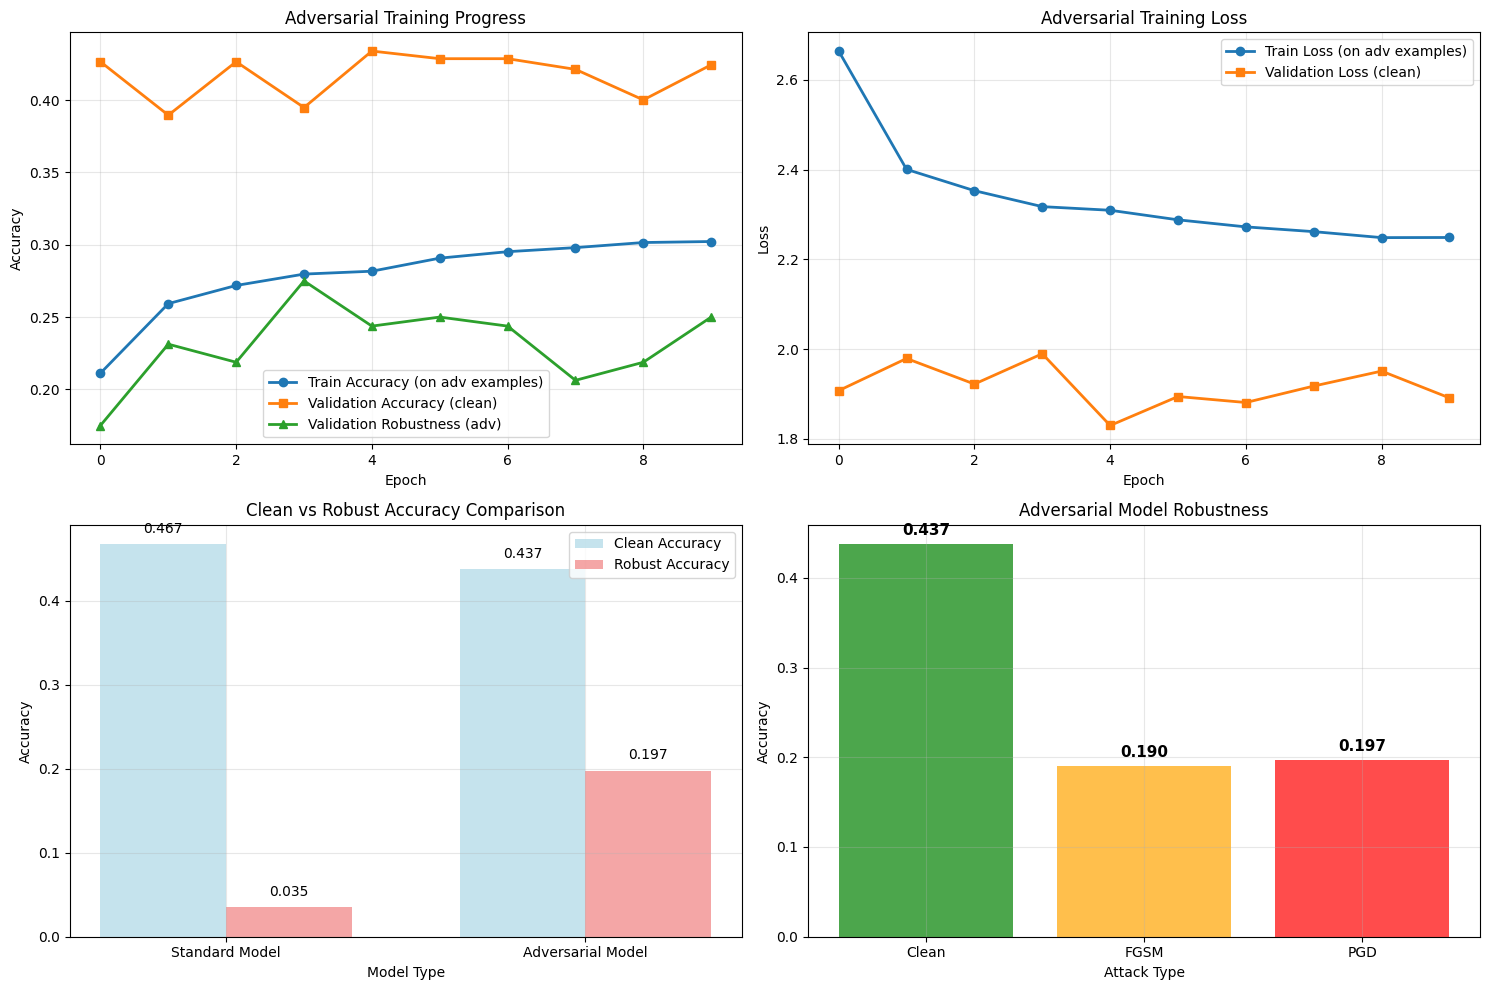


ADVERSARIAL TRAINING ANALYSIS:
----------------------------------------

1. TRAINING EFFECTIVENESS:
   • Robustness improvement: +16.26%
   • Clean accuracy trade-off: -2.96%
   ✓ Significant robustness improvement achieved
   ✓ Minimal clean accuracy loss

2. ATTACK RESISTANCE:
   • PGD resistance ratio: 0.452
   • FGSM resistance ratio: 0.435
   ⚠ Limited resistance to PGD attacks

3. ADVERSARIAL TRAINING INSIGHTS:
   Adversarial training improves robustness at the cost of clean accuracy. PGD training helps create more robust decision boundaries, and the model learns to be invariant to small perturbations. A trade-off between clean and robust performance is therefore expected.

4. FINAL ROBUSTNESS METRICS:
   • Clean accuracy: 0.4372 (43.72%)
   • PGD robustness: 0.1975 (19.75%)
   • FGSM robustness: 0.1901 (19.01%)


In [47]:
print("="*60)
print("ADVERSARIAL TRAINING ANALYSIS")
print("="*60)

# Plot adversarial training progress
plt.figure(figsize=(15, 10))

# Plot training progress
plt.subplot(2, 2, 1)
plt.plot(adv_history['train_acc'], label='Train Accuracy (on adv examples)', linewidth=2, marker='o')
plt.plot(adv_history['val_acc'], label='Validation Accuracy (clean)', linewidth=2, marker='s')
plt.plot(adv_history['robust_acc'], label='Validation Robustness (adv)', linewidth=2, marker='^')
plt.title('Adversarial Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss progress
plt.subplot(2, 2, 2)
plt.plot(adv_history['train_loss'], label='Train Loss (on adv examples)', linewidth=2, marker='o')
plt.plot(adv_history['val_loss'], label='Validation Loss (clean)', linewidth=2, marker='s')
plt.title('Adversarial Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare robustness before and after adversarial training
plt.subplot(2, 2, 3)
if 'clean_acc' in locals() and 'robust_acc' in locals():
    models = ['Standard Model', 'Adversarial Model']
    clean_accs = [clean_acc, adv_clean_acc]
    robust_accs = [robust_acc, adv_pgd_acc]

    x = np.arange(len(models))
    width = 0.35

    bars1 = plt.bar(x - width/2, clean_accs, width, label='Clean Accuracy', alpha=0.7, color='lightblue')
    bars2 = plt.bar(x + width/2, robust_accs, width, label='Robust Accuracy', alpha=0.7, color='lightcoral')

    plt.xlabel('Model Type')
    plt.ylabel('Accuracy')
    plt.title('Clean vs Robust Accuracy Comparison')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Plot robustness against different attacks
plt.subplot(2, 2, 4)
attack_types = ['Clean', 'FGSM', 'PGD']
adv_model_accs = [adv_clean_acc, adv_fgsm_acc, adv_pgd_acc]
colors = ['green', 'orange', 'red']

bars = plt.bar(range(len(attack_types)), adv_model_accs, color=colors, alpha=0.7)
plt.xlabel('Attack Type')
plt.ylabel('Accuracy')
plt.title('Adversarial Model Robustness')
plt.xticks(range(len(attack_types)), attack_types)
for i, acc in enumerate(adv_model_accs):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed analysis
print("\nADVERSARIAL TRAINING ANALYSIS:")
print("-" * 40)

print("\n1. TRAINING EFFECTIVENESS:")
if 'clean_acc' in locals() and 'robust_acc' in locals():
    robustness_improvement = (adv_pgd_acc - robust_acc) * 100
    clean_acc_trade_off = (clean_acc - adv_clean_acc) * 100

    print(f"   • Robustness improvement: +{robustness_improvement:.2f}%")
    print(f"   • Clean accuracy trade-off: -{clean_acc_trade_off:.2f}%")

    if robustness_improvement > 10:
        print("   ✓ Significant robustness improvement achieved")
    elif robustness_improvement > 5:
        print("   ✓ Moderate robustness improvement")
    else:
        print("   ⚠ Limited robustness improvement")

    if clean_acc_trade_off < 5:
        print("   ✓ Minimal clean accuracy loss")
    elif clean_acc_trade_off < 10:
        print("   ⚠ Moderate clean accuracy loss")
    else:
        print("   ⚠ Significant clean accuracy loss")

print(f"\n2. ATTACK RESISTANCE:")
pgd_resistance = adv_pgd_acc / adv_clean_acc
fgsm_resistance = adv_fgsm_acc / adv_clean_acc

print(f"   • PGD resistance ratio: {pgd_resistance:.3f}")
print(f"   • FGSM resistance ratio: {fgsm_resistance:.3f}")

if pgd_resistance > 0.8:
    print("   ✓ Strong resistance to PGD attacks")
elif pgd_resistance > 0.6:
    print("   ✓ Good resistance to PGD attacks")
else:
    print("   ⚠ Limited resistance to PGD attacks")

print(f"\n3. ADVERSARIAL TRAINING INSIGHTS:")
print(f"   Adversarial training improves robustness at the cost of clean accuracy. PGD training helps create more robust decision boundaries, and the model learns to be invariant to small perturbations. A trade-off between clean and robust performance is therefore expected.")

print(f"\n4. FINAL ROBUSTNESS METRICS:")
print(f"   • Clean accuracy: {adv_clean_acc:.4f} ({adv_clean_acc*100:.2f}%)")
print(f"   • PGD robustness: {adv_pgd_acc:.4f} ({adv_pgd_acc*100:.2f}%)")
print(f"   • FGSM robustness: {adv_fgsm_acc:.4f} ({adv_fgsm_acc*100:.2f}%)")

print("="*60)


### <span style="color:red">**Question 3.8 (Kaggle competition)**</span>
<div style="text-align: right"> <span style="color:red">[10 points]</span> </div10

You can reuse the best model obtained in this assignment or develop new models to evaluate on the **testing set of the assignment Kaggle competion**. However, to gain any points for this question, your testing accuracy must **exceed** the accuracy threshold from a base model developed by us as shown in the leader board of the competition.

The marks for this question are as follows:
- If you are in *top 10%* of your cohort, you gain *10 points*.
- If you are in *top 20%* of your cohort, you gain *8 points*.
- If you *beat* the second boss model, you gain *6 points*.
- If you *beat* the first boss model, you gain *4 points*.

Moreover, if you rank in the top 10 of the entire cohort, you will receive a prestigious certificate signed by a renowned professor from our Faculty of Information Technology — a valuable highlight for your CV.
And for the overall winner, we have a special prize: *a book of your choice from Amazon, worth up to 150 AUDs*.